# Learn to play Sapce Invaders 

In this notebook, we'll build a neural network that can learn to play sapce invaders through reinforcement learning.   


This Project requires the following libraries to be installed:

 - gym 
 
 Run the code cell below to install all needed libraries

In [32]:
#GAME = "Breakout-v0"
GAME = "SpaceInvaders-v0" 

## 1 - Space Invaders Data Analysis   :

'SpaceInvaders-v0' GYM environment will be used in developing and comparing several reinforcement learning algorithms.   
In this environment, the observation is an RGB image of the screen (frame), which is an array of shape (210, 160, 3) and for every frame the agent can do the following:
-	Shoot without moving.
-	Move right
-	Move left
-	Shoot and move right
-	Shoot and move left
-	No operation. 

Below a basic code to generate Space Invaders state environment for 1 second (30 frames)  

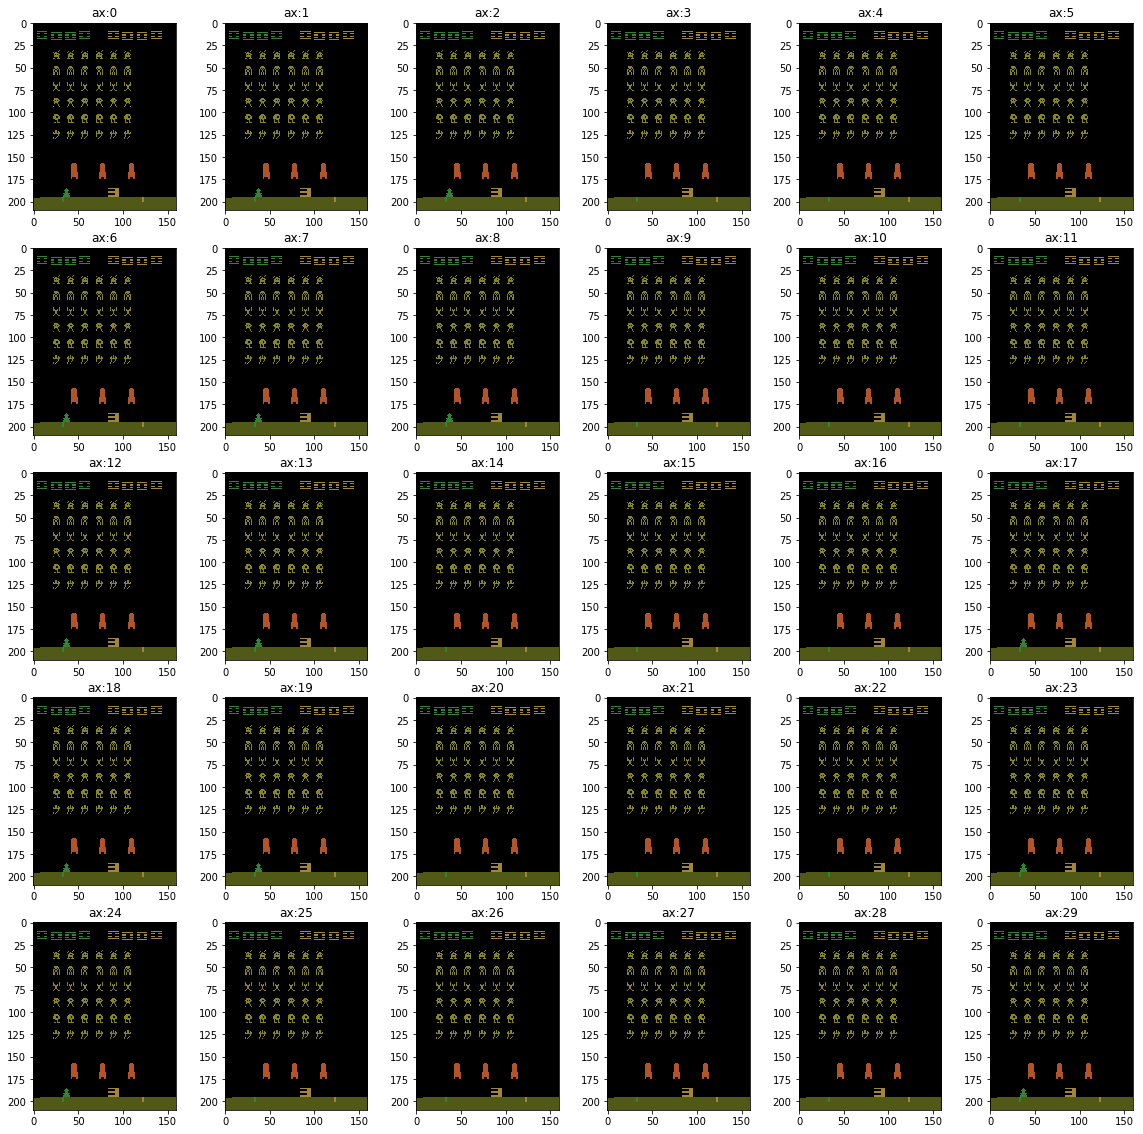

In [34]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.pyplot as plt 
from ipywidgets import widgets
from IPython.display import display 
from matplotlib import animation 
from time import gmtime, strftime
import random
import cv2
import sys 
import numpy as np  
import gym
from collections import defaultdict 
from collections import deque   
import os.path

w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 6
rows = 5
env = gym.make(GAME) 

#xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
#ys = np.abs(np.sin(xs))           # absolute of sine

ax = []
observation = env.reset()
for i in range( columns*rows ):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)     
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(np.array(np.squeeze( observation )))
 

plt.show()  # finally, render the plot

 


Two helper functions that can be used to plot all episodes and steps result and export these data to csv files:
 - plot_agent_matrix_per_step 
     - will plot the loss , explore value e , reward and Q for every step  
 - plot_agent_matrix_per_episode
     - will plot the  score , reward mean per episode, Q mean episode and Q best for every episode 


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.ticker import NullFormatter  
def plot_agent_matrix_per_step(step,loss, explore ,reward , q,name="plot_agent_matrix_per_step"): 
    f = plt.figure(figsize=(20,20))  
    
    with open(name + ".csv", 'a') as csvFile:
        for i in step:
            row = [step[i-1],loss[i-1], explore[i-1], reward[i-1],q[i-1]]
            writer = csv.writer(csvFile)
            writer.writerow(row) 
    csvFile.close()
    
    
    ax = f.add_subplot(221) 
    ax.plot(step, loss)  
    ax.set_title(" gradient descent step Loss")
     
    ax2 = f.add_subplot(222)
    ax2.plot(step, explore)  
    ax2.set_title("Explore or Exploit value per step from 1 to 0.1") 
    
    ax3 = f.add_subplot(223)
    ax3.plot(step, reward)  
    ax3.set_title("The reward in one Step ") 
    
    ax4 = f.add_subplot(224)
    ax4.plot(step, q)  
    ax4.set_title("policy’s estimated action-value Q") 
    plt.show() 
    
    
def plot_agent_matrix_per_episode(episode,score, reward_mean, q_mean,q_best ,name="plot_agent_matrix_per_episode.csv"):    
    # plot with various axes scales
    f = plt.figure(figsize=(20,20))  
    
    with open(name + ".csv", 'a') as csvFile:
        for i in episode:
            row = [episode[i-1],score[i-1], reward_mean[i-1], q_mean[i-1],q_best[i-1]]
            writer = csv.writer(csvFile)
            writer.writerow(row) 
    csvFile.close()
    
    # score
    ax = f.add_subplot(221) #plt.subplot(111)
    ax.plot(episode, score)  
    ax.set_title("The total reward that the agent collects in an episode (score)")
 
    # reward_mean
    ax2 = f.add_subplot(222)#plt.subplot(222)
    ax2.plot(episode, reward_mean) 
    ax2.set_title("The average reward that the agent collects in an episode (mean per episode)")
 
    # q_mean
    ax3 = f.add_subplot(223)#plt.subplot(222)
    ax3.plot(episode, q_mean)  
    ax3.set_title("The average policy’s estimated action-value function (Q) in an episode")
 
    # q_best
    ax4 = f.add_subplot(224)#plt.subplot(222)
    ax4.plot(episode, q_best)  
    ax4.set_title("The best policy’s estimated action-value function (Q) in an episode")
     
    
    plt.show() 
    
def compare_two_agent_matrix(episode,score_1,score_2,q_mean_1 ,q_mean_2,name="compare_two_agent_matrix.txt"): 
       
    f = plt.figure(figsize=(20,20))  
    ax3 = f.add_subplot(121)#plt.subplot(222)
    ax3.plot(episode, score_1, label='Score_1 1') 
    ax3.plot(episode, score_2, label='Score_1 2')  
    ax3.set_title("The total reward that the agent collects in an episode (score)")
   
  
    ax4 = f.add_subplot(122)#plt.subplot(222)
    ax4.plot(episode, q_mean_1, label='Q mean 1') 
    ax4.plot(episode, q_mean_2, label='Q mean 2')  
    ax4.set_title("The average policy’s estimated action-value function (Q) in an episode")
  
    plt.show()  
    plt.legend()
    _ = plt.ylim() 
 

## 2- Evaluate Image pre-processing  algorithms :

- We will use open CV to pre-process our image as following:

  - Crop the header and the bottom of the screen
  
  - Turning the image to grayscale and resizing the image 84 x 84 x 1
  - Evaluating different image pre-processing algorithms that may boost our model learning.
    - Simple Thresholding
    - Adaptive Gaussian Thresholding
    - Adaptive Mean Thresholding 
    - Gaussian Blurring
    - Otsu’s Binarization
    - Image gradients such as Laplacian, sobelx and sobely 

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt 
from ipywidgets import widgets
from IPython.display import display 
from matplotlib import animation 
from time import gmtime, strftime
import random
import cv2
import sys 
import numpy as np  
import gym
from collections import defaultdict 
from collections import deque 
import csv

def preprocess( thresholding  ,
                image_gradients , 
                width_scale,
                height_scale,
                observation ,
                is_gray): 
    
    depth  = observation.shape[2] 
    #top_border = int(height_scale * cut_top_border)
    #bottom_border = int(height_scale * cut_bottom_border)
    
    new_width  = int(width_scale * observation.shape[1]) 
    new_height = int(height_scale * observation.shape[0])
    
    #observation = observation[top_border:new_height-bottom_border,:] 
    #new_width  = int(height_scale * observation.shape[1]) 
    #new_height = int(height_scale * observation.shape[0])
 
    if(is_gray): 
        observation = cv2.cvtColor(cv2.resize(observation, (new_width, new_height)), cv2.COLOR_BGR2GRAY)
        depth  = 1
    else:
        observation = cv2.resize(observation, (new_width, new_height))
       
    width  = observation.shape[0]
    height = observation.shape[1]  
    
    size = width * height * depth

    if(thresholding == "THRESH_BINARY"): 
        ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY) 
    elif(thresholding == "ADAPTIVE_THRESH_MEAN"): 
        observation =cv2.adaptiveThreshold(observation,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)  
    elif(thresholding == "ADAPTIVE_THRESH_GAUSSIAN"): 
        observation = cv2.adaptiveThreshold(observation,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2) 
    elif(thresholding == "2D_Convolution"): 
        kernel = np.ones((5,5),np.float32)/50
        observation = cv2.filter2D(observation,-1,kernel)  
    elif(thresholding == "THRESH_OTSU_GaussianBlur"): 
        blur = cv2.GaussianBlur(observation,(5,5),0)
        ret,observation = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
     
    if(image_gradients == "laplacian"):
        observation = cv2.Laplacian(observation,cv2.CV_64F)
    elif(image_gradients == "sobelx"):
        observation = cv2.Sobel(observation,cv2.CV_64F,1,0,ksize=15)   
    elif(image_gradients == "sobely"):
        observation = cv2.Sobel(observation,cv2.CV_64F,0,1,ksize=15)  
    
    observation = np.reshape(observation, ( width ,height,depth)) 

    return observation , size ,width ,height ,depth
 
def cut_sapce_invaders_border( observation):
    if(GAME == "SpaceInvaders-v0" or GAME == "Breakout-v0"):
        observation = observation[22:200,:]
        return np.reshape(observation, (178  ,160,3))
    else:
        return observation
    
    
def show_space_invaders_image( thresholding = "Orignal" ,
                               image_gradients = "Orignal", 
                               width_scale = 1,
                               height_scale =1 , 
                               is_gray = True, 
                               stop_at_episode =0):
    env = gym.make(GAME)
    observation = env.reset()
      
    if(stop_at_episode > 0 ):
        for t in range(stop_at_episode): 
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            if done:
                break 
                
    observation = cut_sapce_invaders_border( observation) 
    observation , size ,width ,height ,depth = preprocess(thresholding,
                                               image_gradients,  
                                               width_scale,
                                               height_scale,
                                               observation,
                                               is_gray)
   
    print(size)  
    print(observation.shape[0]*observation.shape[1]*observation.shape[2])
    print( " thresholding: " +thresholding + " image_gradients:" +image_gradients + str(np.array(observation).shape))
    plt.imshow(np.array(np.squeeze(observation)))
    plt.show() 
    env.close()
      

85440
85440
 thresholding: Orignal image_gradients:Orignal(178, 160, 3)


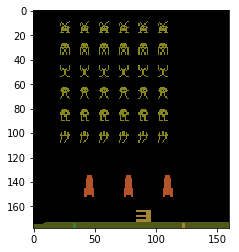

25600
25600
 thresholding: Orignal image_gradients:Orignal(160, 160, 1)


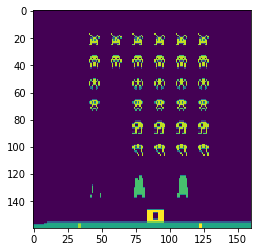

15876
15876
 thresholding: Orignal image_gradients:Orignal(126, 126, 1)


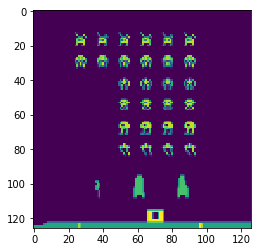

7056
7056
 thresholding: Orignal image_gradients:Orignal(84, 84, 1)


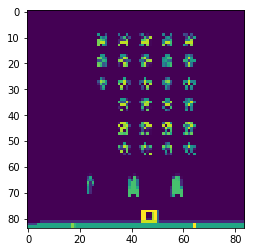

1764
1764
 thresholding: Orignal image_gradients:Orignal(42, 42, 1)


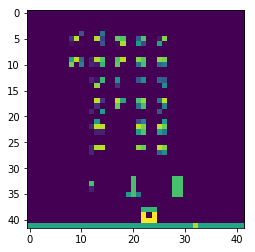

In [37]:
show_space_invaders_image(width_scale = 1,
                          height_scale =1,
                          is_gray = False , 
                          stop_at_episode = 0)

show_space_invaders_image(width_scale = 1,
                          height_scale =0.9,
                          is_gray = True , 
                          stop_at_episode = 3000)


show_space_invaders_image(width_scale = 0.79,
                          height_scale =0.71,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image(width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image(width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 3000)



try diffrent resoultion with diffrent time step for example after 3 second to ensure that all object are clear and can be recoginze by CNN 

7056
7056
 thresholding: Orignal image_gradients:laplacian(84, 84, 1)


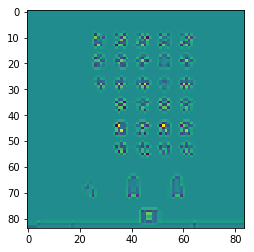

7056
7056
 thresholding: Orignal image_gradients:sobelx(84, 84, 1)


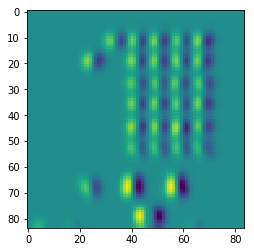

7056
7056
 thresholding: Orignal image_gradients:sobely(84, 84, 1)


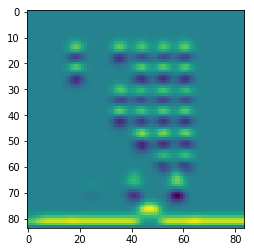

In [38]:

show_space_invaders_image( 
                          image_gradients = "laplacian", 
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image( 
                          image_gradients = "sobelx", 
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image( 
                          image_gradients = "sobely", 
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 3000)

1764
1764
 thresholding: Orignal image_gradients:laplacian(42, 42, 1)


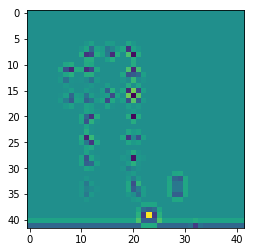

1764
1764
 thresholding: Orignal image_gradients:sobelx(42, 42, 1)


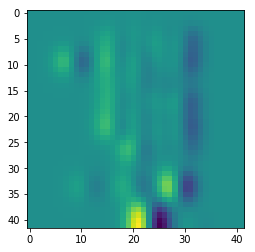

1764
1764
 thresholding: Orignal image_gradients:sobely(42, 42, 1)


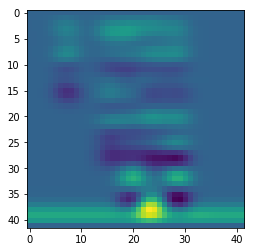

In [39]:

show_space_invaders_image( 
                          image_gradients = "laplacian", 
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image( 
                          image_gradients = "sobelx", 
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 3000)

show_space_invaders_image( 
                          image_gradients = "sobely", 
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 3000)

7056
7056
 thresholding: THRESH_BINARY image_gradients:Orignal(84, 84, 1)


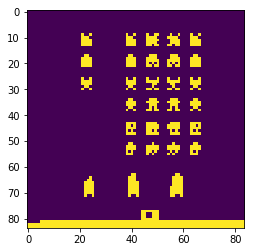

7056
7056
 thresholding: ADAPTIVE_THRESH_MEAN image_gradients:Orignal(84, 84, 1)


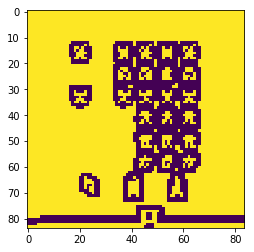

7056
7056
 thresholding: ADAPTIVE_THRESH_GAUSSIAN image_gradients:Orignal(84, 84, 1)


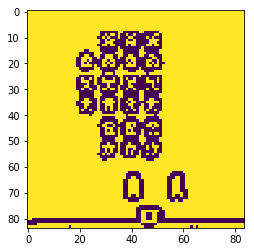

7056
7056
 thresholding: 2D_Convolution image_gradients:Orignal(84, 84, 1)


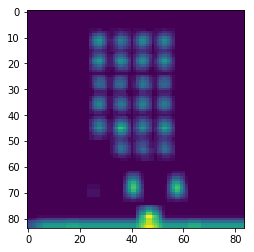

In [40]:
show_space_invaders_image(thresholding ="THRESH_BINARY",
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 2000) 

show_space_invaders_image(thresholding ="ADAPTIVE_THRESH_MEAN",
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 2000) 

show_space_invaders_image(thresholding ="ADAPTIVE_THRESH_GAUSSIAN",
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 2000) 


show_space_invaders_image(thresholding ="2D_Convolution",
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 2000) 

7056
7056
 thresholding: THRESH_OTSU_GaussianBlur image_gradients:Orignal(84, 84, 1)


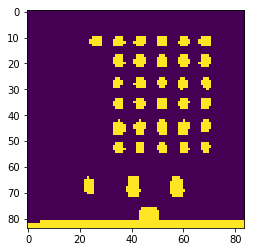

In [41]:


show_space_invaders_image(thresholding ="THRESH_OTSU_GaussianBlur",
                          width_scale = 0.525,
                          height_scale =0.475,
                          is_gray = True , 
                          stop_at_episode = 2000) 
  

1764
1764
 thresholding: THRESH_BINARY image_gradients:Orignal(42, 42, 1)


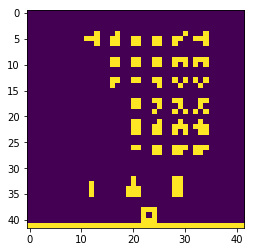

1764
1764
 thresholding: ADAPTIVE_THRESH_MEAN image_gradients:Orignal(42, 42, 1)


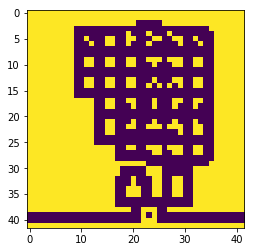

1764
1764
 thresholding: ADAPTIVE_THRESH_GAUSSIAN image_gradients:Orignal(42, 42, 1)


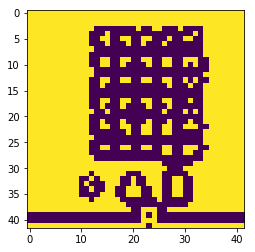

1764
1764
 thresholding: 2D_Convolution image_gradients:Orignal(42, 42, 1)


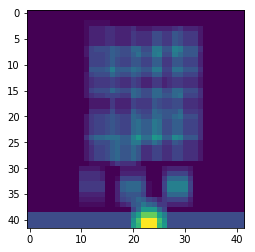

1764
1764
 thresholding: THRESH_OTSU_GaussianBlur image_gradients:Orignal(42, 42, 1)


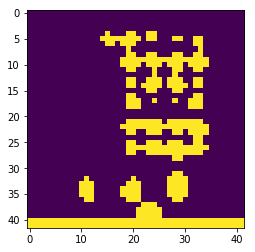

In [42]:
show_space_invaders_image(thresholding ="THRESH_BINARY",
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 2000) 

show_space_invaders_image(thresholding ="ADAPTIVE_THRESH_MEAN",
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 2000) 

show_space_invaders_image(thresholding ="ADAPTIVE_THRESH_GAUSSIAN",
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 2000) 
 
show_space_invaders_image(thresholding ="2D_Convolution",
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 2000) 

show_space_invaders_image(thresholding ="THRESH_OTSU_GaussianBlur",
                          width_scale = 0.265,
                          height_scale =0.24,
                          is_gray = True , 
                          stop_at_episode = 2000) 
  
    
    

This is to build three reinforcement learning Agents   
 - Deep Q Learning agent that has a 24 x 24 fully connected network  
 - Double Deep Q Learning agent that has two 24 x 24 fully connected networks. One as model and the second will be used as target model and will be responsible to predict the future action in Q learning algorithm.  
 - Random Agent that will act randomly  


In [43]:
import numpy as np
import random 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
from keras import layers, models, optimizers, regularizers  
from keras.layers import merge, Input 
from keras.models import load_model, Sequential, Model
from keras.layers.convolutional import Convolution2D 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) 
  
class DQNAgent:
    
    def __init__(self, 
                 state_size,
                 action_size , 
                 action_low  ,
                 hight , 
                 width , 
                 depth,
                 network_type = "dqn",
                 cnn_network = "deep_mind",
                 learning_rate = 0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay_rate = 0.0001  
        #self.epsilon_decay = 0.995
        self.learning_rate = learning_rate #0.001
        self.tau = 0.01
        
        
        self.hight = hight
        self.width = width
        self.depth = depth
        self.action_low = action_low  
        self.network_type = network_type  
        self.cnn_network = cnn_network
        self.model = self._build_deep_cnn_network() 
        self.target = self._build_deep_cnn_network() 
    
    def _get_deep_mind_cnn_network(self):
        input_layer = Input(shape = (self.hight, self.width, self.depth))
        
        conv2D1 = Conv2D(filters= 32, 
                         kernel_size=8, 
                         strides=(4, 4), 
                         padding='valid',
                         activation='relu')(input_layer)
         
        conv2D2 = Conv2D(filters=64, 
                         kernel_size=4, 
                         strides=(2, 2), 
                         padding='valid', 
                         activation='relu')(conv2D1)
        
        conv2D3 = Conv2D(filters=64, 
                         kernel_size=3, 
                         strides=(1, 1), 
                         padding='valid', 
                         activation='relu')(conv2D2) 
        flatten = Flatten()(conv2D3)
        
        full_connected_network = Dense(512)(flatten)
        full_connected_network = keras.layers.LeakyReLU()(full_connected_network)

        deep_mind_cnn = Dense(self.action_size, activation='linear')(full_connected_network) 
        
        return  input_layer ,deep_mind_cnn 
    
    
    
    def _build_deep_cnn_network(self):
        if(self.cnn_network  == "deep_mind"):
            input_layer , cnn_network  = self._get_deep_mind_cnn_network() 
            model = Sequential() 
            model = Model(input=[input_layer], output=[cnn_network])
            #model.compile(loss=self.get_huber_loss, optimizer=Adam(lr=self.learning_rate))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
            model.summary()
            return model
        elif(self.cnn_network  == "fully_connected_cnn_24_24"): 
            model = Sequential()  
            model.add(Dense(24, input_dim=self.state_size, activation='relu')) 
            model.add(Dense(24, activation='relu')) 
            #model.add(Dense(64, activation='relu'))  
            model.add(Dense(self.action_size, activation='linear')) 
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate)) 
            model.summary()
            return model
        
     
    def get_huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        
        condition =  K.abs(error) < clip_delta 
        
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(condition, squared_loss, quadratic_loss))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def get_explore_value(self,t):
        return self.epsilon_min + (self.epsilon - self.epsilon_min)* np.exp(-self.epsilon_decay_rate*t) 
     
    # t is the current step 
    def act(self, state,t): 
        act_values = self.model.predict(state)  
        action = 0.0
        q=0.0
        explore = self.get_explore_value(t) 
        if np.random.rand() <= explore:
            action = random.randrange(self.action_size) 
        else:
            action = np.argmax(act_values[0]) 
            
        q = act_values[0][action] 
        return action, q    
      
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size) 
        x = []
        y = []
        
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state) 
            if(done): 
                target[0][action] = reward
            else:  
                if(self.network_type == "ddqn"):
                    target[0][action] = reward + self.gamma * np.amax(self.target.predict(next_state)[0])
                else:
                    target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) 
            
            x.append(state[0])
            y.append(target[0])
              
        history = self.model.fit(np.array(x), np.array(y), epochs=1, verbose=0) 
         
        loss = history.history['loss'][0]
        
        return loss , self.epsilon
    
         
            
    def replay_target_model(self):
        model_weights = self.model.get_weights() 
        if(self.network_type == "ddqn"):
            self.target.set_weights(model_weights)
             
    def save_network(self, path): 
        self.model.save(path)
        print("  Successfully saved network.")

    def load_network(self, path):
        #self.model = load_model(path, custom_objects={'loss': self.get_huber_loss})
        self.model = load_model(path)
        print("  Succesfully loaded network.")
        

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4245238033304525280
]


In [44]:
def preprocess_states(env,
                      base_state,
                      action,
                      preprocess_method,
                      frame_number = 1):
     
    base_state ,size,hight,width,depth  = preprocess_state(cut_sapce_invaders_border( base_state) , preprocess_method) 
        
    if(frame_number > 1): 
        for i in range(frame_number -1):
            next_state, reward, done, info = env.step(action)  
            next_state ,size,width,hight,depth= preprocess_state(cut_sapce_invaders_border( next_state) , preprocess_method)

            base_state = np.concatenate((base_state, next_state), axis=2)
          
    #base_state = np.expand_dims(base_state, axis=0)  
    
    hight = base_state.shape[0]
    width = base_state.shape[1]
    depth = base_state.shape[2]
    size = hight * width * depth
    #print("\r( h {:4d}, w {:4d}, d {:4d})".format(
    #        hight, width ,depth), end="")  
    return base_state ,size,hight,width,depth 
             

def preprocess_state(state, 
                     preprocess_method):
    
      
    size = state.shape[0] * state.shape[1] *state.shape[2]  
        
    hight  = state.shape[0]
    width = state.shape[1] 
    depth = state.shape[2] 
    if(preprocess_method == "THRESH_BINARY_25"): 
        state , size,hight,width,depth  = preprocess("THRESH_BINARY"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.265,
                                                       height_scale =0.24,
                                                       observation = state,
                                                       is_gray = True  )
    elif(preprocess_method == "THRESH_OTSU_GaussianBlur_50"): 
        state , size,hight,width,depth  = preprocess("THRESH_OTSU_GaussianBlur"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True   )
    elif(preprocess_method == "THRESH_BINARY_50"): 
        state , size,hight,width,depth  = preprocess("THRESH_BINARY"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True  )
    
    elif(preprocess_method == "ADAPTIVE_THRESH_MEAN_50"): 
        state , size,hight,width,depth  = preprocess("ADAPTIVE_THRESH_MEAN"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True   )
    
    elif(preprocess_method == "ADAPTIVE_THRESH_GAUSSIAN_50"): 
        state , size,hight,width,depth  = preprocess("ADAPTIVE_THRESH_GAUSSIAN"  ,
                                                       image_gradients = "",
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True   )
        
    elif(preprocess_method == "2D_Convolution_50"): 
        state , size,hight,width,depth  = preprocess("2D_Convolution"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True  )
    
    elif(preprocess_method == "laplacian_50"): 
        state , size,hight,width,depth  = preprocess("laplacian"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True   )
        
    elif(preprocess_method == "Orignal_100"): 
        state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "", 
                                                       width_scale = 1,
                                                       height_scale =0.9,
                                                       observation = state,
                                                       is_gray = True  )
        
    elif(preprocess_method == "Orignal_75"): 
         state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.79,
                                                       height_scale =0.71,
                                                       observation = state,
                                                       is_gray = True  )
        
    elif(preprocess_method == "Orignal_50"): 
         state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "", 
                                                       width_scale = 0.525,
                                                       height_scale =0.475,
                                                       observation = state,
                                                       is_gray = True   )
        
    elif(preprocess_method == "Orignal_25"): 
         state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "",  
                                                       width_scale = 0.265,
                                                       height_scale =0.24,
                                                       observation = state,
                                                       is_gray = True  )
    elif(preprocess_method == "Orignal_15"): 
         state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "",  
                                                       width_scale =0.15,
                                                       height_scale =0.14,
                                                       observation = state,
                                                       is_gray = True  ) 
    else:
        state , size,hight,width,depth  = preprocess("Orignal"  ,
                                                       image_gradients = "", 
                                                       width_scale = 1,
                                                       height_scale =0.9,
                                                       observation = state,
                                                       is_gray = True  )   
        
        
    #print(state.shape[0])
    #print(state.shape[1])
    #print(state.shape[2])
    #print(size) 
    return state , size,hight,width,depth
  
def run_DQN_agent_to_play_space_invaders(num_episodes,
                                         preprocess_method,
                                         result,
                                         save_network_path,
                                         allowRender =False ,
                                         is_random  = False ,
                                         number_of_frames = 1 , 
                                         network_type = "dqn", 
                                         cnn_nework = "fully_connected_cnn_24_24",
                                         update_target_every = 1000,
                                         learning_rate = 0.001):
     
    env = gym.make(GAME)
 
    _ , state_size,width,hight,depth = preprocess_state(cut_sapce_invaders_border(env.reset()) ,preprocess_method) 
    agent = DQNAgent(state_size,
                     env.action_space.n,
                     0,
                     hight,
                     width,
                     (depth * number_of_frames) ,
                     network_type,
                     cnn_nework,
                     learning_rate) 
    
    if(cnn_nework == "deep_mind"):
        isConv = True
    else:
        isConv = False
        
    run_agent(agent = agent , 
              env = env,
              num_episodes = num_episodes,
              state_size = state_size,
              preprocess_method = preprocess_method,
              result = result,
              save_network_path = save_network_path,
              allowRender = allowRender,
              is_random  = is_random ,
              number_of_frames = number_of_frames,
              isConv = isConv,
              update_target_every = update_target_every)
    env.close()     
    
def run_agent(agent, 
              env,
              num_episodes,
              state_size ,
              preprocess_method, 
              result, 
              save_network_path,
              allowRender =False ,
              is_random  = False ,
              number_of_frames = 1,
              isConv = False,
              update_target_every = 1000):
     

    if(os.path.exists(save_network_path) and not is_random):
        agent.load_network(save_network_path) 
        
    report_every = 1
    action_size = env.action_space.n
    batch_size = 32
    result["episode"] = [] 
    result["reward_mean"] = []
    result["score"] = [] 
    result["q_best"] = []  
    result["q_mean"] = []  
    
    result["step"] = [] 
    result["loss"] = [] 
    result["reward"] = []
    result["explore"] = [] 
    result["q"] = [] 

    episode_counter = 0
    total_q_episodes_per_report= 0.0
    total_score_episodes_per_report= 0.0
    total_t_episodes_per_report = 0.0
    episode_best_q = -10000
    #update_target_every = 1000
    
    frame_counter = 0
    step = 0
    q_mean = 0
    score  = 0 
    reward_mean = 0 
    loss = [0]
    loss[0] = 0
     
    for i_episode in range(1, num_episodes+1):
        state = env.reset()  
        action = random.randrange(action_size) 
        state , size,_,_,_ = preprocess_states(env,state,action ,preprocess_method,number_of_frames) 
         
        if(isConv):
            state = np.expand_dims(state, axis=0) 
        else:
            state = np.reshape(state, [1, size])    
      
        episode_counter = episode_counter  + 1
        episode_score = 0.0
        episode_q = 0.0  
        
        for t  in range(1, 2000+1):  
            if(allowRender):
                env.render() 
            
            step = step + 1
            result["step"].append(step)
            explore =  agent.get_explore_value(step) 
            result["explore"].append(explore)

            frame_counter = frame_counter + 1
            #get action 
            
            if(is_random):
                 action , q =  random.randrange(action_size) , 0
            else:
                 action , q = agent.act(state,step)
                     
            episode_q = episode_q + q 
            result["q"].append(q) 
            
            if(episode_best_q < q):
                episode_best_q =   q 
            
            #take action  
            next_state, reward, done, info = env.step(action)    
            episode_score = episode_score + reward
            result["reward"].append(reward)

            
            next_state , size,_,_,_ = preprocess_states(env,next_state,action ,preprocess_method,number_of_frames)  
            if(isConv):
                next_state = np.expand_dims(next_state, axis=0)
            else:
                next_state = np.reshape(next_state, [1, size])    
            agent.remember(state, action, reward, next_state, done)
            state = next_state  
            
            if(not is_random and step % update_target_every == 0):
                agent.replay_target_model(); 

            if done: 
                result["loss"].append(0)
                break
                
            if (not is_random and len(agent.memory) > batch_size) :  
                loss   = agent.replay(batch_size)
                result["loss"].append(loss[0])  
                print("\r step= {:4d} ,  Ep= {:4d} , loss= {:7.3f} explore value = {:7.3f}  score= {:7.3f} , reward mean= {:7.3f}  ,Q mean = {:7.3f} , Q best= {:7.3f}".format(
                     step , i_episode,  loss[0], explore ,score,reward_mean ,  q_mean , episode_best_q), end="")  
                sys.stdout.flush()
            else:
                result["loss"].append(0) 
        
        total_q_episodes_per_report     = total_q_episodes_per_report + (episode_q /t )
        total_score_episodes_per_report = total_score_episodes_per_report + episode_score
        total_t_episodes_per_report     = total_t_episodes_per_report+ t 
                
        if(episode_counter == report_every): 
            q_mean = total_q_episodes_per_report     / report_every  
            score  = total_score_episodes_per_report / report_every 
            t_mean = total_t_episodes_per_report     / report_every  
            reward_mean = score / t_mean
            #cum_reward_mean = total / cum_counter
            result["episode"].append(i_episode)
            result["score"].append(score)  
            result["reward_mean"].append(reward_mean)   
            result["q_mean"].append(q_mean) 
            result["q_best"].append(episode_best_q)   
            episode_counter = 0
            total_q_episodes_per_report = 0.0
            total_score_episodes_per_report =0.0
            total_t_episodes_per_report = 0.0 
        #if step % 10 == 0: 
        if(not is_random):
            agent.save_network(save_network_path)
                
        env.close() 

In [ ]:
space_invaders_random_orignal_24_24 =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =1000,
                                     preprocess_method = "Orignal_50",
                                     result = space_invaders_random_orignal_24_24,
                                     save_network_path  = "space_invaders_random_orignal_24_24.h5",
                                     is_random  = True ,
                                     number_of_frames  = 1 ,
                                     network_type = "dqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24")  #deep_mind fully_connected_cnn_24_24

result = space_invaders_random_orignal_24_24  

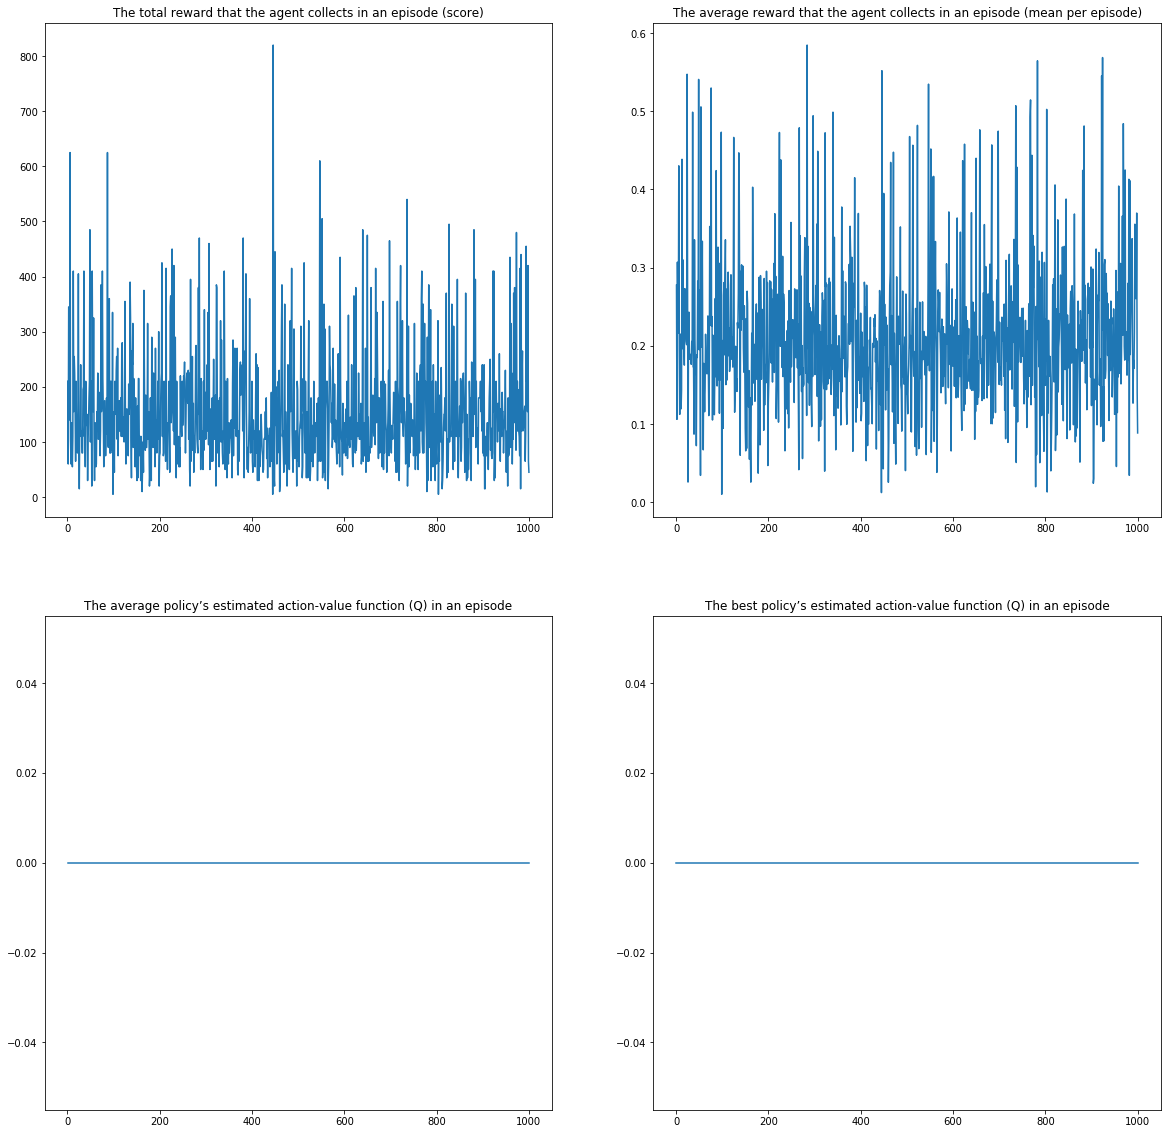

In [16]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"] ,
                              "space_random_dqn_orignal_24_24_episodes")

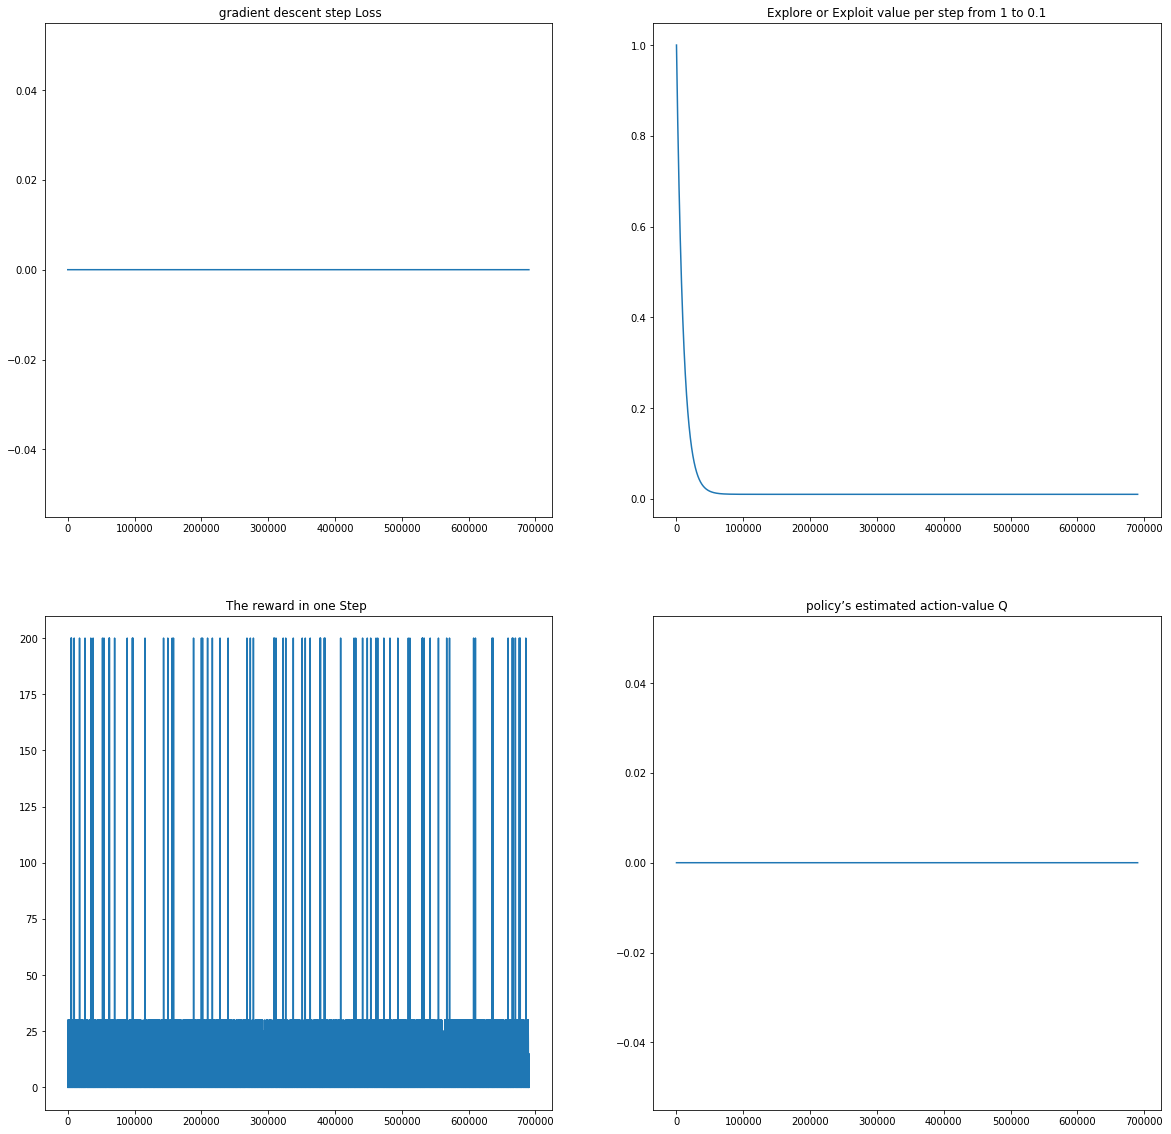

In [17]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_random_dqn_orignal_24_24_step")

In [20]:
space_invaders_dqn_orignal_24_24 =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =250,
                                     preprocess_method = "Orignal_50",
                                     result = space_invaders_dqn_orignal_24_24, 
                                     save_network_path  = "space_invaders_dqn_orignal_24_24.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "dqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24")  #deep_mind fully_connected_cnn_24_24

result = space_invaders_dqn_orignal_24_24  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_20 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 150       
Total params: 170,118
Trainable params: 170,118
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_23 (Dense)             (None, 24)                600       
_________________________________________________________________
dens

 step= 73583 ,  Ep=   88 , loss=   3.195 explore value =   0.011  score= 105.000 , reward mean=   0.151  ,Q mean =   5.315 , Q best=  11.082  Successfully saved network.
 step= 74391 ,  Ep=   89 , loss=   0.011 explore value =   0.011  score= 180.000 , reward mean=   0.219  ,Q mean =   5.219 , Q best=  11.082  Successfully saved network.
 step= 75204 ,  Ep=   90 , loss=   0.008 explore value =   0.011  score= 180.000 , reward mean=   0.223  ,Q mean =   5.299 , Q best=  11.082  Successfully saved network.
 step= 76071 ,  Ep=   91 , loss=   0.009 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   5.166 , Q best=  11.082  Successfully saved network.
 step= 76885 ,  Ep=   92 , loss=   0.127 explore value =   0.010  score= 210.000 , reward mean=   0.242  ,Q mean =   4.780 , Q best=  11.082  Successfully saved network.
 step= 77712 ,  Ep=   93 , loss=   0.007 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   4.813 , Q best=  11.082  Successf

 step= 165044 ,  Ep=  184 , loss=   1.263 explore value =   0.010  score= 370.000 , reward mean=   0.321  ,Q mean =   4.316 , Q best=  11.082  Successfully saved network.
 step= 165765 ,  Ep=  185 , loss=   0.506 explore value =   0.010  score= 225.000 , reward mean=   0.251  ,Q mean =   4.461 , Q best=  11.082  Successfully saved network.
 step= 167198 ,  Ep=  186 , loss=   4.627 explore value =   0.010  score= 150.000 , reward mean=   0.208  ,Q mean =   4.584 , Q best=  11.082  Successfully saved network.
 step= 168255 ,  Ep=  187 , loss=   0.009 explore value =   0.010  score= 435.000 , reward mean=   0.304  ,Q mean =   4.802 , Q best=  11.082  Successfully saved network.
 step= 168950 ,  Ep=  188 , loss=   0.752 explore value =   0.010  score= 305.000 , reward mean=   0.289  ,Q mean =   4.728 , Q best=  11.082  Successfully saved network.
 step= 170051 ,  Ep=  189 , loss=   0.127 explore value =   0.010  score= 265.000 , reward mean=   0.381  ,Q mean =   4.801 , Q best=  11.082  Su

 step= 208178 ,  Ep=  232 , loss=   1.130 explore value =   0.010  score= 185.000 , reward mean=   0.230  ,Q mean =   7.798 , Q best=  11.082  Successfully saved network.
 step= 209246 ,  Ep=  233 , loss=   1.124 explore value =   0.010  score= 180.000 , reward mean=   0.282  ,Q mean =   7.978 , Q best=  11.082  Successfully saved network.
 step= 210055 ,  Ep=  234 , loss=   0.505 explore value =   0.010  score= 350.000 , reward mean=   0.328  ,Q mean =   8.477 , Q best=  11.082  Successfully saved network.
 step= 210858 ,  Ep=  235 , loss=   0.019 explore value =   0.010  score= 180.000 , reward mean=   0.222  ,Q mean =   8.029 , Q best=  11.082  Successfully saved network.
 step= 212067 ,  Ep=  236 , loss=   0.131 explore value =   0.010  score= 215.000 , reward mean=   0.268  ,Q mean =   7.798 , Q best=  11.082  Successfully saved network.
 step= 213000 ,  Ep=  237 , loss=   0.014 explore value =   0.010  score= 215.000 , reward mean=   0.178  ,Q mean =   7.570 , Q best=  11.082  Su

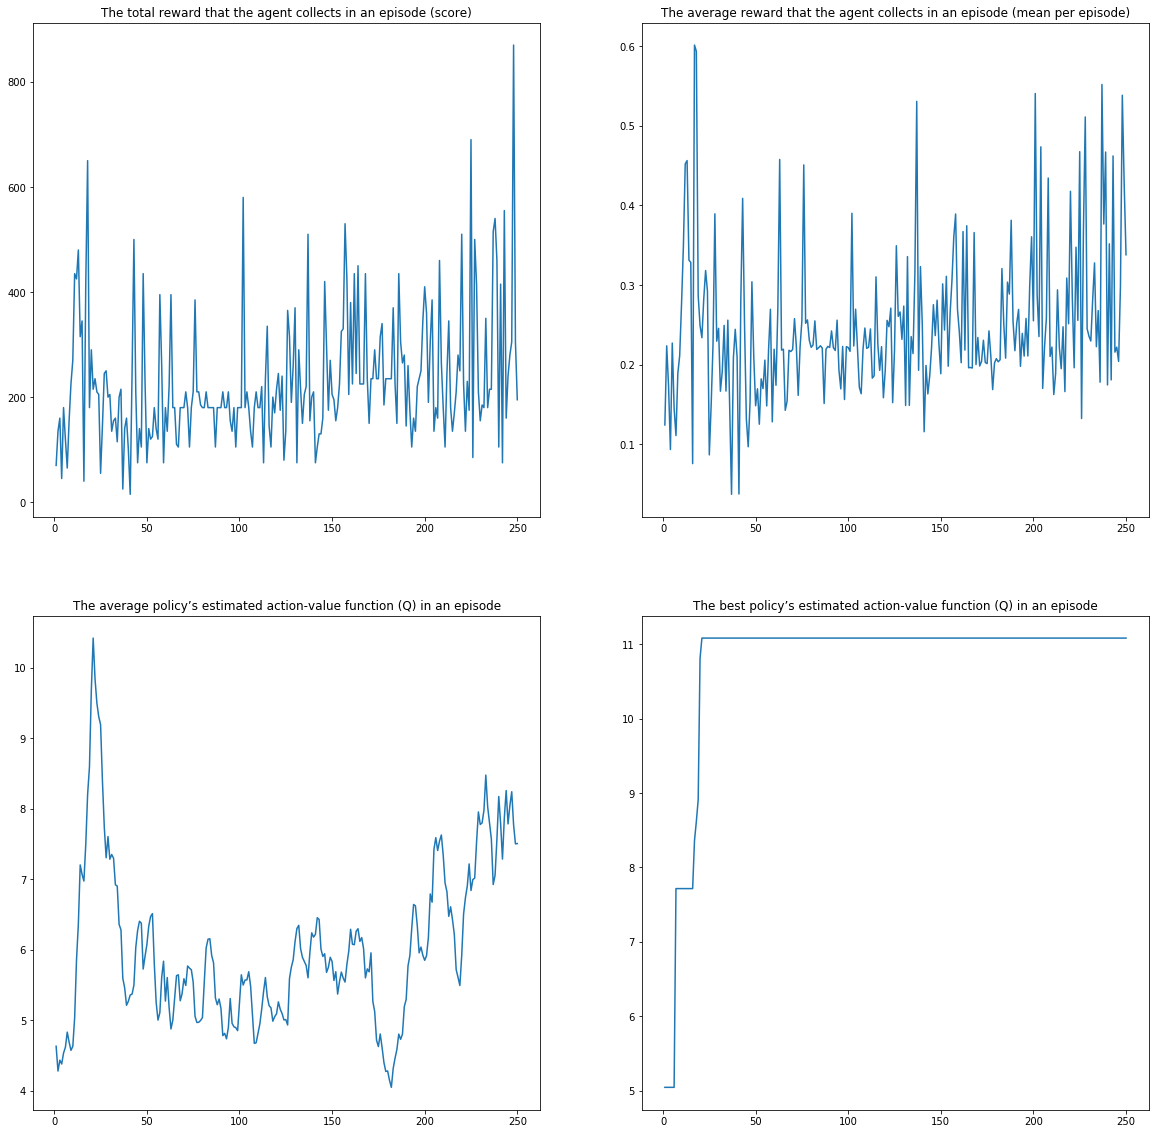

In [21]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_dqn_orignal_24_24_episodes")

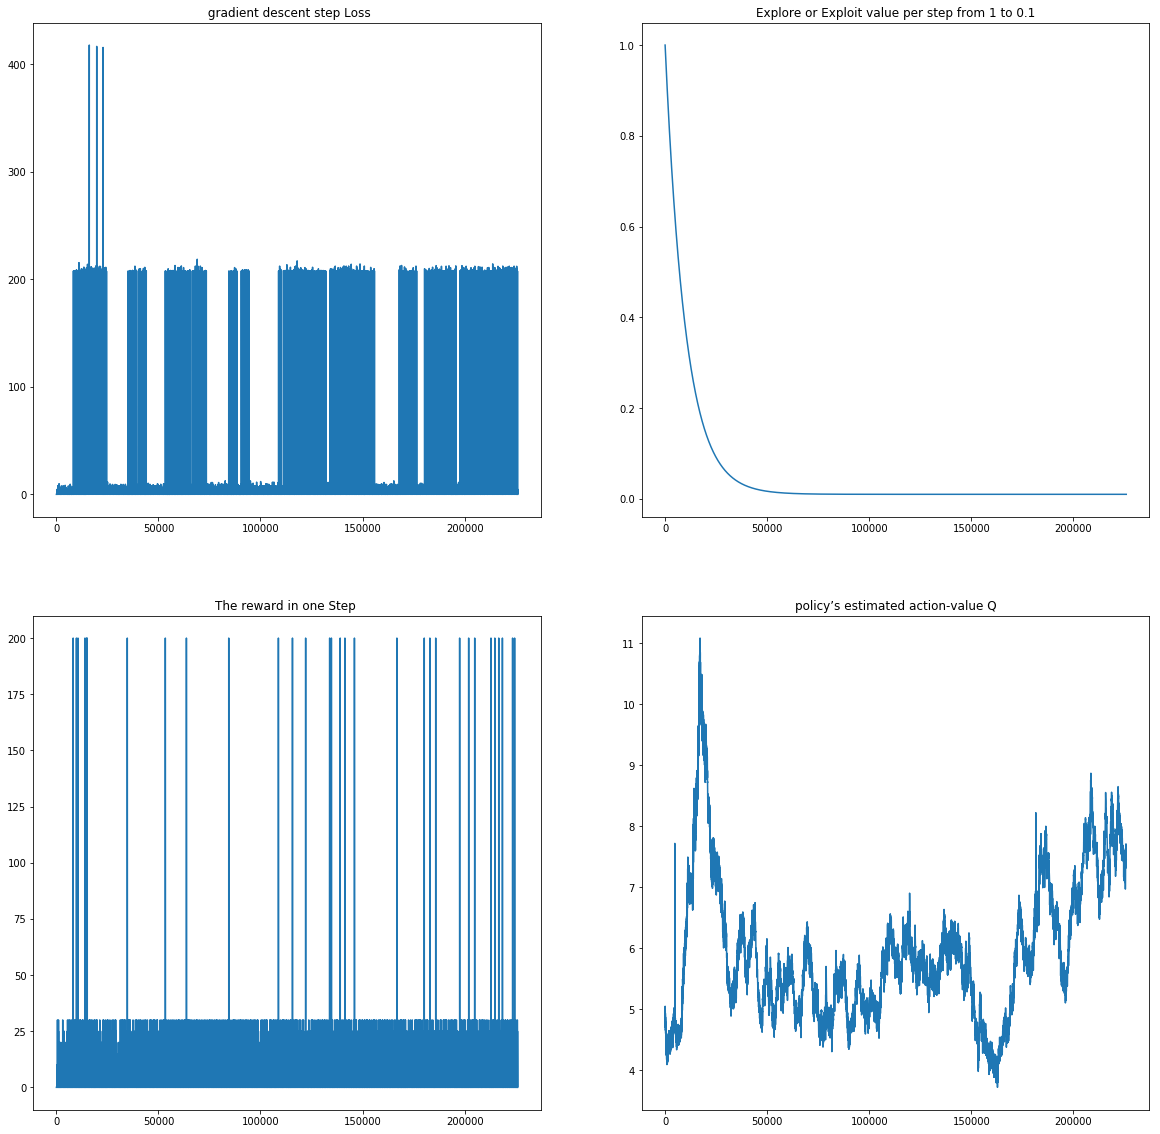

In [22]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_dqn_orignal_24_24_step")

In [17]:
space_invaders_dqn_orignal_24_24_OTSU =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =250,
                                     preprocess_method = "THRESH_OTSU_GaussianBlur",
                                     result = space_invaders_dqn_orignal_24_24_OTSU, 
                                     save_network_path  = "space_invaders_dqn_orignal_24_24_OTSU.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "dqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24")  #deep_mind fully_connected_cnn_24_24

result = space_invaders_dqn_orignal_24_24_OTSU  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 24)                614424    
_________________________________________________________________
dense_18 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 150       
Total params: 615,174
Trainable params: 615,174
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 24)                614424    
_________________________________________________________________
dense_21 (Dense)             (None, 24)                600       
_________________________________________________________________
dens

 step= 70122 ,  Ep=   87 , loss=   0.528 explore value =   0.011  score= 165.000 , reward mean=   0.244  ,Q mean =   7.123 , Q best= 16451.201  Successfully saved network.
 step= 71072 ,  Ep=   88 , loss=   0.129 explore value =   0.011  score= 315.000 , reward mean=   0.325  ,Q mean =   6.452 , Q best= 16451.201  Successfully saved network.
 step= 71807 ,  Ep=   89 , loss=   0.010 explore value =   0.011  score= 265.000 , reward mean=   0.279  ,Q mean =   6.545 , Q best= 16451.201  Successfully saved network.
 step= 72463 ,  Ep=   90 , loss=   0.014 explore value =   0.011  score= 215.000 , reward mean=   0.293  ,Q mean =   6.421 , Q best= 16451.201  Successfully saved network.
 step= 73994 ,  Ep=   91 , loss=   0.017 explore value =   0.011  score= 100.000 , reward mean=   0.152  ,Q mean =   6.636 , Q best= 16451.201  Successfully saved network.
 step= 74936 ,  Ep=   92 , loss=   4.598 explore value =   0.011  score= 665.000 , reward mean=   0.434  ,Q mean =   6.563 , Q best= 16451.2

 step= 152297 ,  Ep=  181 , loss=   0.501 explore value =   0.010  score= 105.000 , reward mean=   0.171  ,Q mean =   7.330 , Q best= 16451.201  Successfully saved network.
 step= 153310 ,  Ep=  182 , loss=   0.525 explore value =   0.010  score= 445.000 , reward mean=   0.391  ,Q mean =   6.617 , Q best= 16451.201  Successfully saved network.
 step= 154240 ,  Ep=  183 , loss=   0.017 explore value =   0.010  score= 250.000 , reward mean=   0.247  ,Q mean =   6.787 , Q best= 16451.201  Successfully saved network.
 step= 154910 ,  Ep=  184 , loss=   0.127 explore value =   0.010  score= 205.000 , reward mean=   0.220  ,Q mean =   6.863 , Q best= 16451.201  Successfully saved network.
 step= 155552 ,  Ep=  185 , loss=   0.013 explore value =   0.010  score= 175.000 , reward mean=   0.261  ,Q mean =   6.694 , Q best= 16451.201  Successfully saved network.
 step= 156750 ,  Ep=  186 , loss=   0.501 explore value =   0.010  score= 175.000 , reward mean=   0.273  ,Q mean =   6.151 , Q best= 1

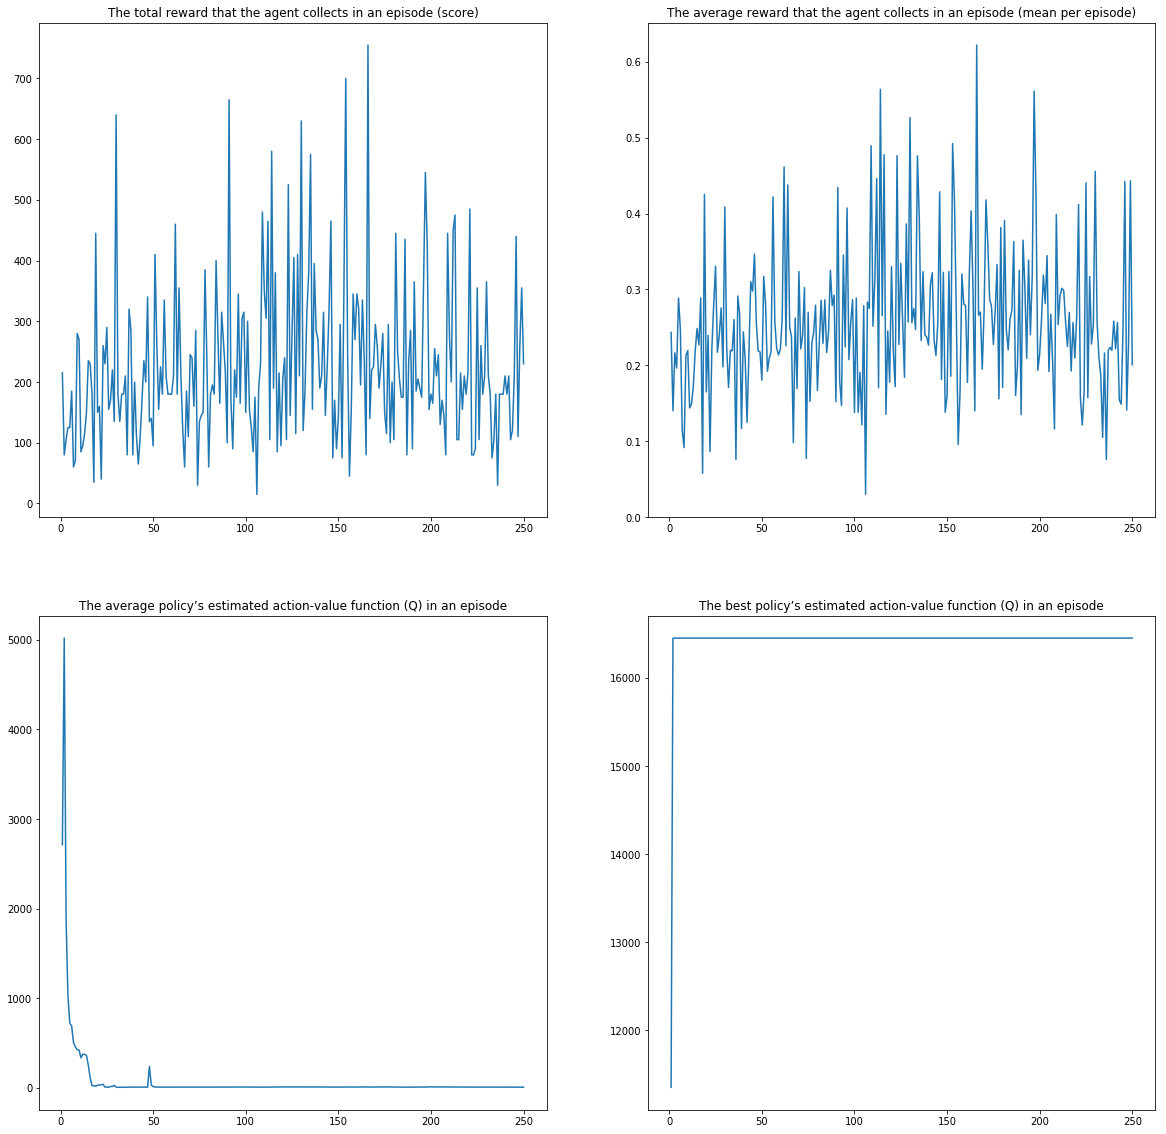

In [18]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_dqn_orignal_24_24_otsu_episodes")

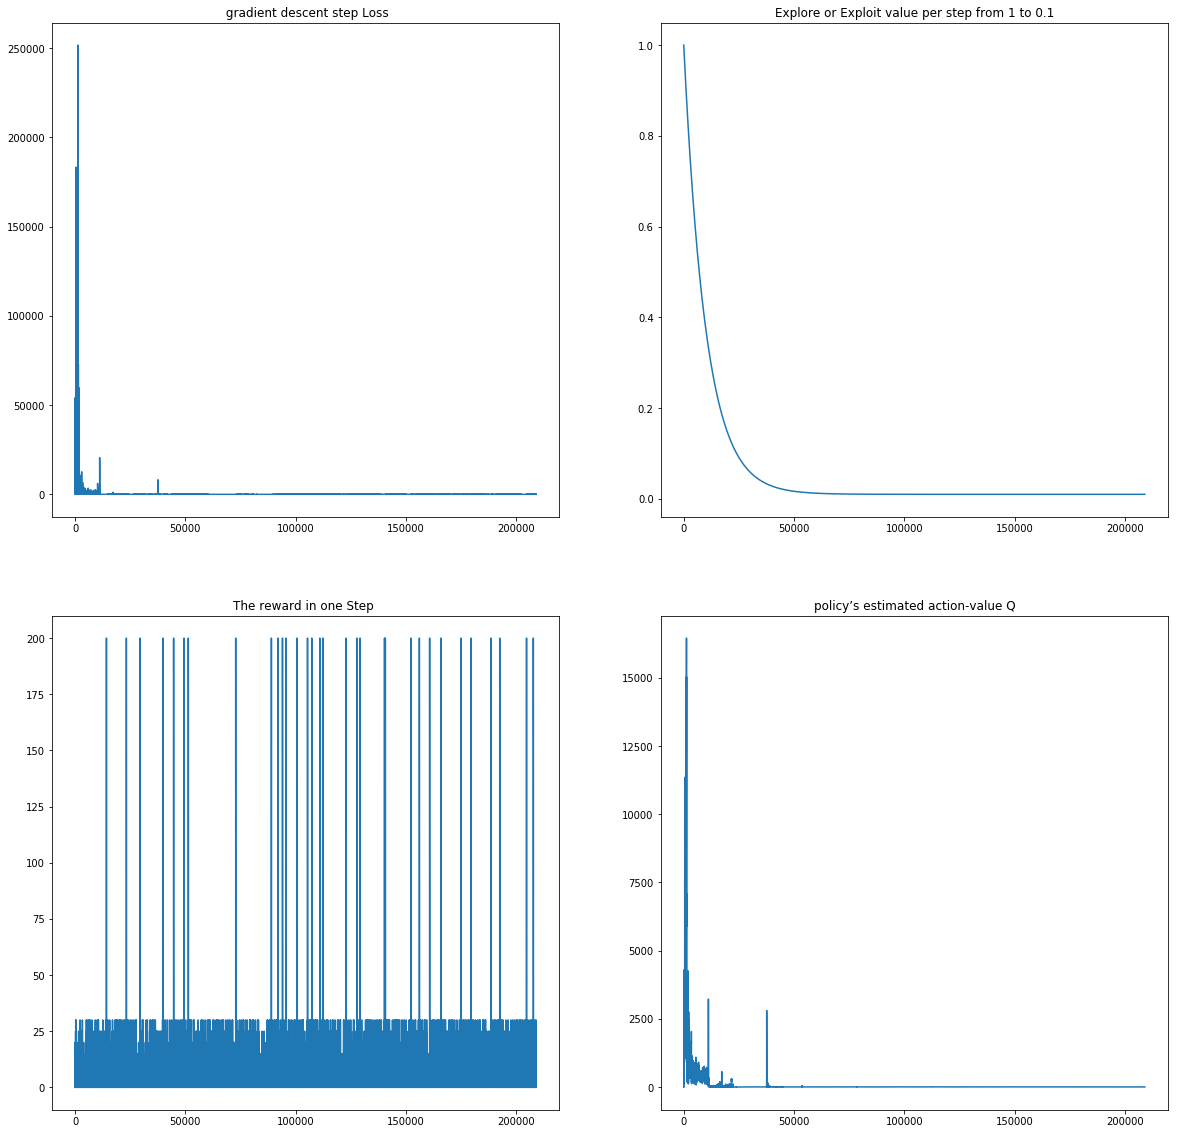

In [19]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_dqn_orignal_24_24_otsu_step")

In [14]:
space_invaders_ddqn_orignal_24_24 =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =250,
                                     preprocess_method = "Orignal_50",
                                     result = space_invaders_ddqn_orignal_24_24, 
                                     save_network_path  = "space_invaders_ddqn_orignal_24_24.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "ddqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24")  #deep_mind fully_connected_cnn_24_24

result = space_invaders_ddqn_orignal_24_24  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                169368    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 170,118
Trainable params: 170,118
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                169368    
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dens

 step= 71090 ,  Ep=   88 , loss=   0.152 explore value =   0.011  score= 300.000 , reward mean=   0.266  ,Q mean =  12.605 , Q best=  85.817  Successfully saved network.
 step= 71738 ,  Ep=   89 , loss=   0.755 explore value =   0.011  score= 535.000 , reward mean=   0.353  ,Q mean =  11.045 , Q best=  85.817  Successfully saved network.
 step= 72943 ,  Ep=   90 , loss=   2.125 explore value =   0.011  score= 185.000 , reward mean=   0.285  ,Q mean =  12.887 , Q best=  85.817  Successfully saved network.
 step= 73955 ,  Ep=   91 , loss=   0.195 explore value =   0.011  score= 270.000 , reward mean=   0.224  ,Q mean =  11.782 , Q best=  85.817  Successfully saved network.
 step= 74338 ,  Ep=   92 , loss=   0.180 explore value =   0.011  score= 535.000 , reward mean=   0.529  ,Q mean =  12.252 , Q best=  85.817  Successfully saved network.
 step= 74902 ,  Ep=   93 , loss=   0.104 explore value =   0.011  score= 105.000 , reward mean=   0.274  ,Q mean =  12.782 , Q best=  85.817  Successf

 step= 149016 ,  Ep=  184 , loss=   0.060 explore value =   0.010  score=  65.000 , reward mean=   0.098  ,Q mean =   7.581 , Q best=  85.817  Successfully saved network.
 step= 149728 ,  Ep=  185 , loss=   0.019 explore value =   0.010  score= 165.000 , reward mean=   0.265  ,Q mean =   8.494 , Q best=  85.817  Successfully saved network.
 step= 151417 ,  Ep=  186 , loss=   0.799 explore value =   0.010  score= 165.000 , reward mean=   0.232  ,Q mean =   8.268 , Q best=  85.817  Successfully saved network.
 step= 152452 ,  Ep=  187 , loss= 208.419 explore value =   0.010  score= 820.000 , reward mean=   0.485  ,Q mean =   7.313 , Q best=  85.817  Successfully saved network.
 step= 153464 ,  Ep=  188 , loss=   0.029 explore value =   0.010  score= 410.000 , reward mean=   0.396  ,Q mean =   7.666 , Q best=  85.817  Successfully saved network.
 step= 154099 ,  Ep=  189 , loss=   0.812 explore value =   0.010  score= 430.000 , reward mean=   0.425  ,Q mean =   8.166 , Q best=  85.817  Su

 step= 192914 ,  Ep=  232 , loss=   0.009 explore value =   0.010  score= 365.000 , reward mean=   0.256  ,Q mean =   7.147 , Q best=  85.817  Successfully saved network.
 step= 193651 ,  Ep=  233 , loss=   0.031 explore value =   0.010  score= 245.000 , reward mean=   0.275  ,Q mean =   7.096 , Q best=  85.817  Successfully saved network.
 step= 194909 ,  Ep=  234 , loss=   0.081 explore value =   0.010  score= 240.000 , reward mean=   0.326  ,Q mean =   7.261 , Q best=  85.817  Successfully saved network.
 step= 196216 ,  Ep=  235 , loss=   0.711 explore value =   0.010  score= 215.000 , reward mean=   0.171  ,Q mean =   6.820 , Q best=  85.817  Successfully saved network.
 step= 196900 ,  Ep=  236 , loss=   0.125 explore value =   0.010  score= 165.000 , reward mean=   0.126  ,Q mean =   7.702 , Q best=  85.817  Successfully saved network.
 step= 197457 ,  Ep=  237 , loss=   0.016 explore value =   0.010  score= 175.000 , reward mean=   0.256  ,Q mean =   7.181 , Q best=  85.817  Su

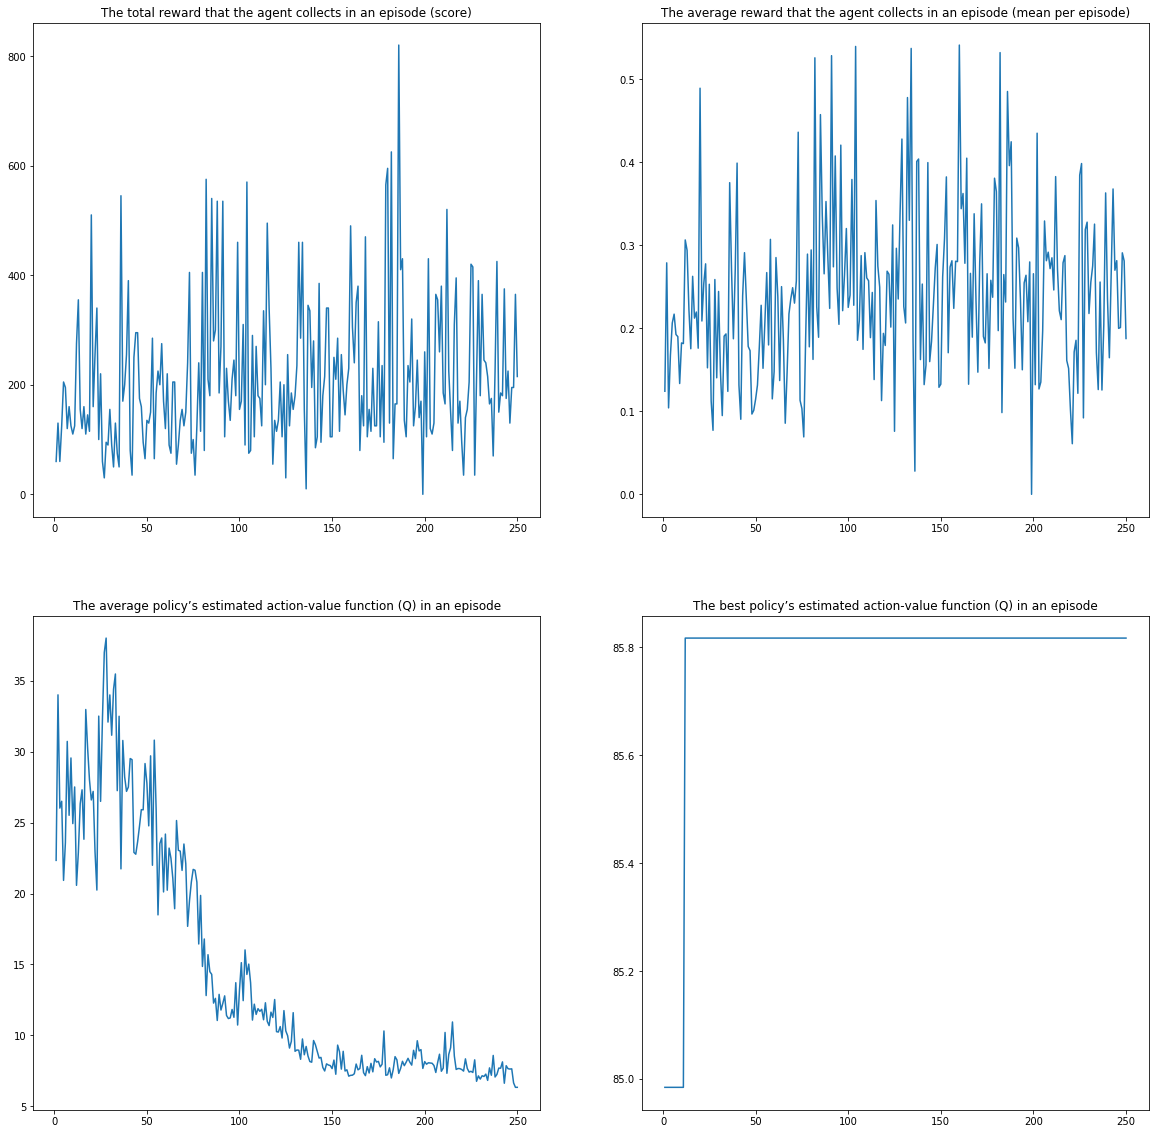

In [19]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_ddqn_orignal_deep_mind_episodes")

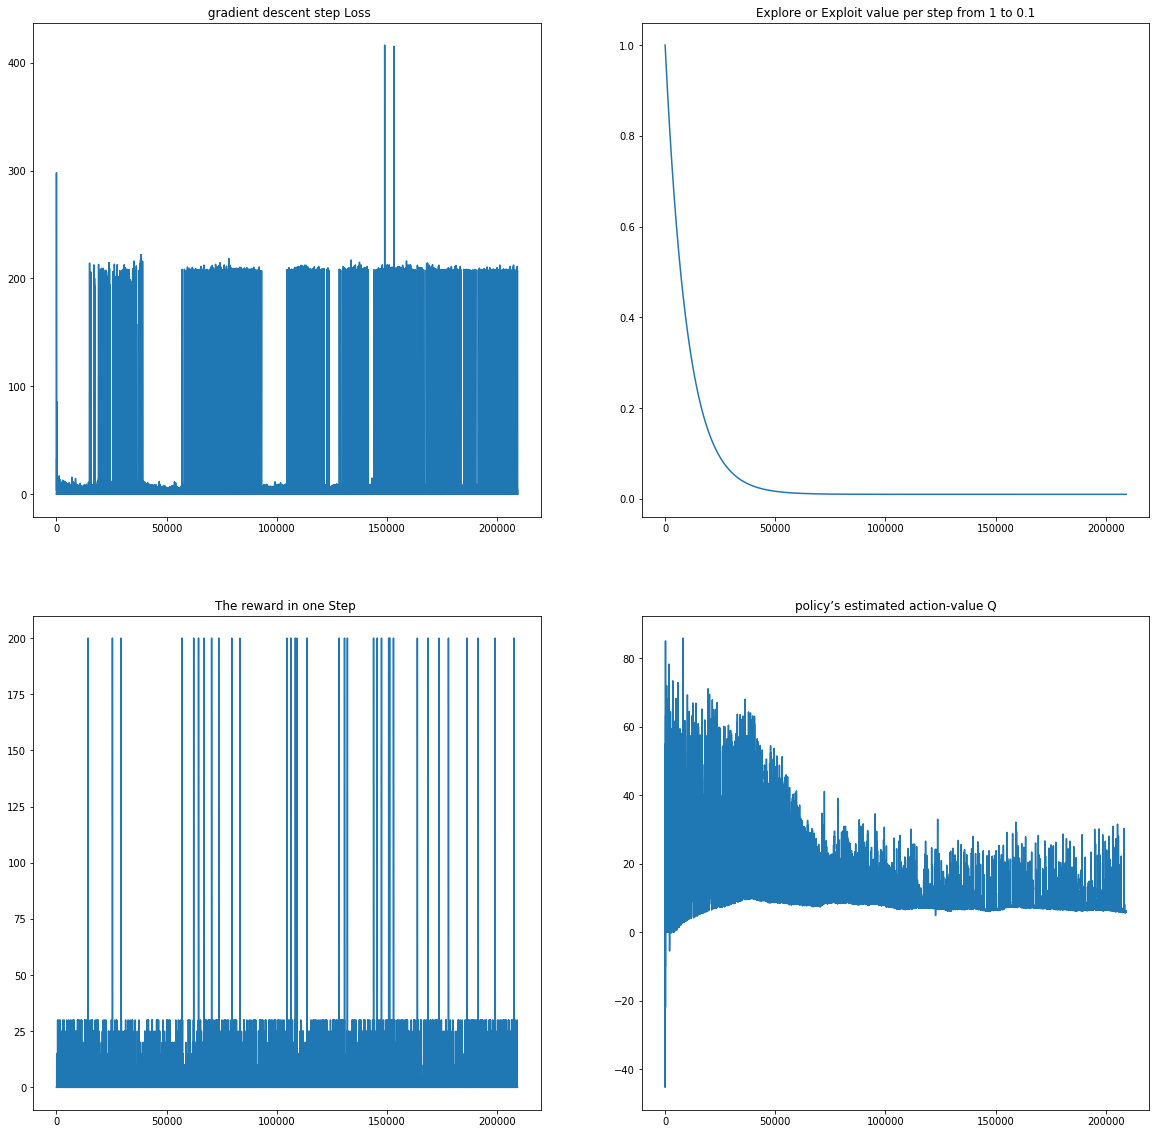

In [20]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_ddqn_orignal_deep_mind_step")

In [48]:
space_invaders_ddqn_orignal_24_24 =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =250,
                                     preprocess_method = "Orignal_50",
                                     result = space_invaders_ddqn_orignal_24_24, 
                                     save_network_path  = "space_invaders_ddqn_orignal_24_24.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "ddqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24",#deep_mind fully_connected_cnn_24_24
                                     update_target_every = 500,
                                     learning_rate = 0.0005 
                                     )  

result = space_invaders_ddqn_orignal_24_24  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_44 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 150       
Total params: 170,118
Trainable params: 170,118
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_47 (Dense)             (None, 24)                600       
_________________________________________________________________
dens

 step= 28576 ,  Ep=   40 , loss=   0.013 explore value =   0.067  score= 355.000 , reward mean=   0.262  ,Q mean =   8.564 , Q best= 322.240  Successfully saved network.
 step= 29374 ,  Ep=   41 , loss=   0.014 explore value =   0.062  score= 105.000 , reward mean=   0.217  ,Q mean =   7.266 , Q best= 322.240  Successfully saved network.
 step= 30031 ,  Ep=   42 , loss=   0.262 explore value =   0.059  score= 210.000 , reward mean=   0.263  ,Q mean =   7.138 , Q best= 322.240  Successfully saved network.
 step= 31458 ,  Ep=   43 , loss=   0.011 explore value =   0.053  score=  30.000 , reward mean=   0.046  ,Q mean =   7.125 , Q best= 322.240  Successfully saved network.
 step= 32594 ,  Ep=   44 , loss=   0.019 explore value =   0.048  score= 410.000 , reward mean=   0.287  ,Q mean =   7.920 , Q best= 322.240  Successfully saved network.
 step= 33240 ,  Ep=   45 , loss=   0.012 explore value =   0.046  score= 190.000 , reward mean=   0.167  ,Q mean =   7.931 , Q best= 322.240  Successf

 step= 73521 ,  Ep=   88 , loss=   0.009 explore value =   0.011  score= 385.000 , reward mean=   0.369  ,Q mean =   6.341 , Q best= 322.240  Successfully saved network.
 step= 74328 ,  Ep=   89 , loss=   0.508 explore value =   0.011  score= 165.000 , reward mean=   0.168  ,Q mean =   6.307 , Q best= 322.240  Successfully saved network.
 step= 75131 ,  Ep=   90 , loss=   4.640 explore value =   0.011  score= 210.000 , reward mean=   0.260  ,Q mean =   6.254 , Q best= 322.240  Successfully saved network.
 step= 76110 ,  Ep=   91 , loss=   0.127 explore value =   0.010  score= 245.000 , reward mean=   0.305  ,Q mean =   6.311 , Q best= 322.240  Successfully saved network.
 step= 76764 ,  Ep=   92 , loss=   0.005 explore value =   0.010  score= 235.000 , reward mean=   0.240  ,Q mean =   6.338 , Q best= 322.240  Successfully saved network.
 step= 77419 ,  Ep=   93 , loss=   0.018 explore value =   0.010  score= 105.000 , reward mean=   0.161  ,Q mean =   6.333 , Q best= 322.240  Successf

 step= 114186 ,  Ep=  136 , loss=   0.508 explore value =   0.010  score= 245.000 , reward mean=   0.242  ,Q mean =   6.635 , Q best= 322.240  Successfully saved network.
 step= 114742 ,  Ep=  137 , loss=   0.132 explore value =   0.010  score= 185.000 , reward mean=   0.279  ,Q mean =   6.632 , Q best= 322.240  Successfully saved network.
 step= 115237 ,  Ep=  138 , loss=   0.003 explore value =   0.010  score=  95.000 , reward mean=   0.171  ,Q mean =   6.598 , Q best= 322.240  Successfully saved network.
 step= 116162 ,  Ep=  139 , loss=   2.057 explore value =   0.010  score=  75.000 , reward mean=   0.152  ,Q mean =   6.572 , Q best= 322.240  Successfully saved network.
 step= 116967 ,  Ep=  140 , loss=   0.007 explore value =   0.010  score= 415.000 , reward mean=   0.449  ,Q mean =   6.435 , Q best= 322.240  Successfully saved network.
 step= 117879 ,  Ep=  141 , loss=   3.135 explore value =   0.010  score= 205.000 , reward mean=   0.255  ,Q mean =   6.418 , Q best= 322.240  Su

 step= 154173 ,  Ep=  184 , loss=   1.146 explore value =   0.010  score= 180.000 , reward mean=   0.220  ,Q mean =   7.171 , Q best= 322.240  Successfully saved network.
 step= 155031 ,  Ep=  185 , loss=   0.014 explore value =   0.010  score= 105.000 , reward mean=   0.205  ,Q mean =   7.027 , Q best= 322.240  Successfully saved network.
 step= 155852 ,  Ep=  186 , loss=   0.032 explore value =   0.010  score= 235.000 , reward mean=   0.274  ,Q mean =   6.998 , Q best= 322.240  Successfully saved network.
 step= 156685 ,  Ep=  187 , loss=   0.992 explore value =   0.010  score= 180.000 , reward mean=   0.219  ,Q mean =   6.887 , Q best= 322.240  Successfully saved network.
 step= 157506 ,  Ep=  188 , loss=   2.037 explore value =   0.010  score= 180.000 , reward mean=   0.216  ,Q mean =   6.896 , Q best= 322.240  Successfully saved network.
 step= 158322 ,  Ep=  189 , loss=   0.008 explore value =   0.010  score= 180.000 , reward mean=   0.219  ,Q mean =   6.921 , Q best= 322.240  Su

 step= 194794 ,  Ep=  232 , loss=   2.657 explore value =   0.010  score= 155.000 , reward mean=   0.193  ,Q mean =   5.992 , Q best= 322.240  Successfully saved network.
 step= 195614 ,  Ep=  233 , loss=   0.011 explore value =   0.010  score= 180.000 , reward mean=   0.263  ,Q mean =   6.010 , Q best= 322.240  Successfully saved network.
 step= 195993 ,  Ep=  234 , loss=   0.011 explore value =   0.010  score= 180.000 , reward mean=   0.220  ,Q mean =   6.004 , Q best= 322.240  Successfully saved network.
 step= 196807 ,  Ep=  235 , loss=   0.124 explore value =   0.010  score=  35.000 , reward mean=   0.092  ,Q mean =   6.031 , Q best= 322.240  Successfully saved network.
 step= 197631 ,  Ep=  236 , loss=   5.242 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   6.009 , Q best= 322.240  Successfully saved network.
 step= 198281 ,  Ep=  237 , loss=   0.006 explore value =   0.010  score= 325.000 , reward mean=   0.394  ,Q mean =   5.927 , Q best= 322.240  Su

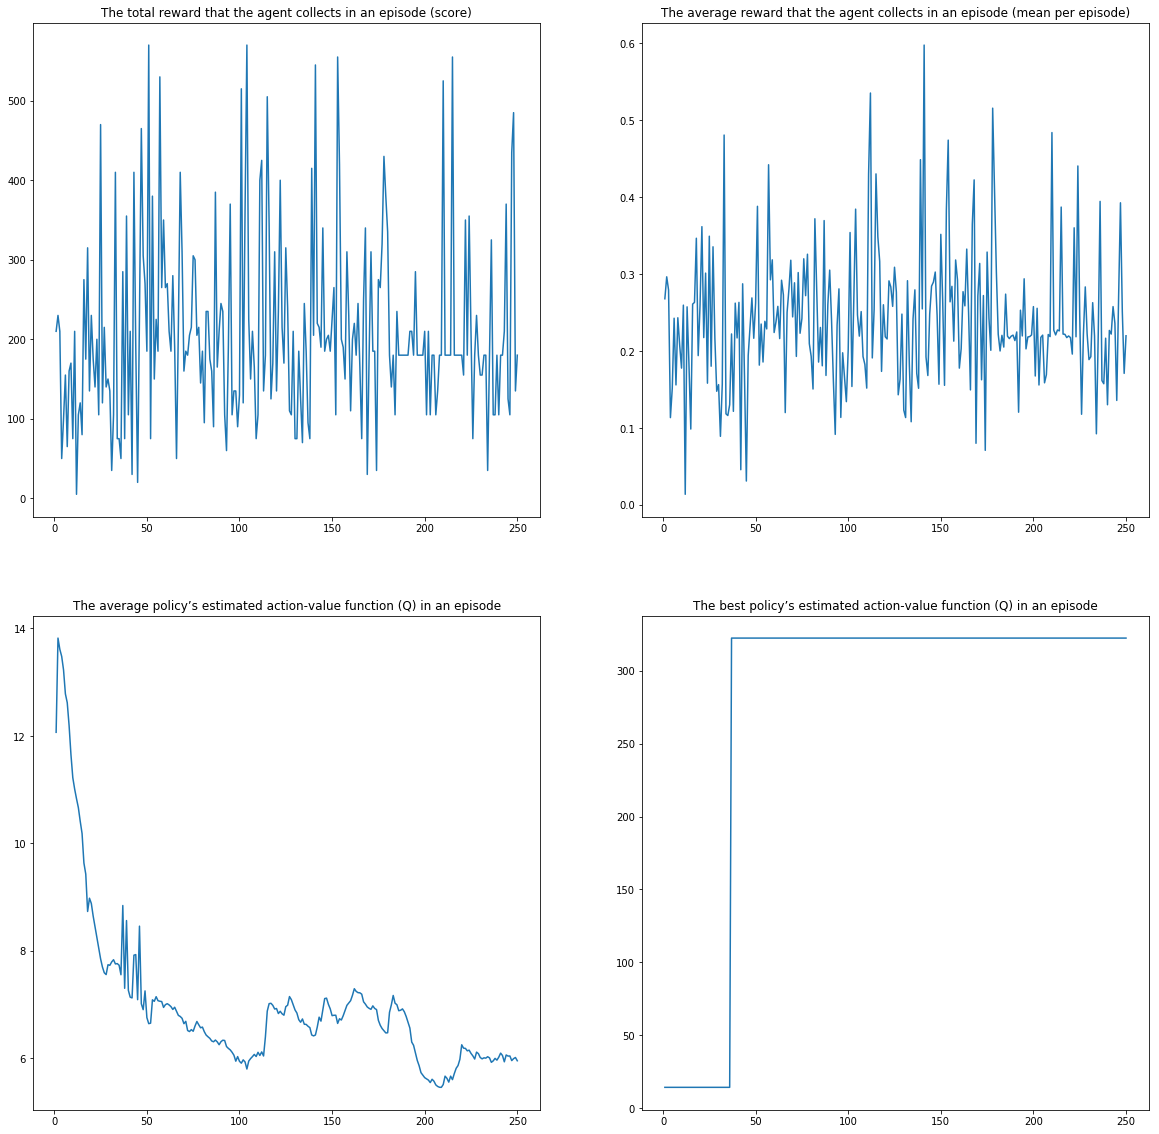

In [49]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_ddqn_orignal_24_24_opt_episodes")

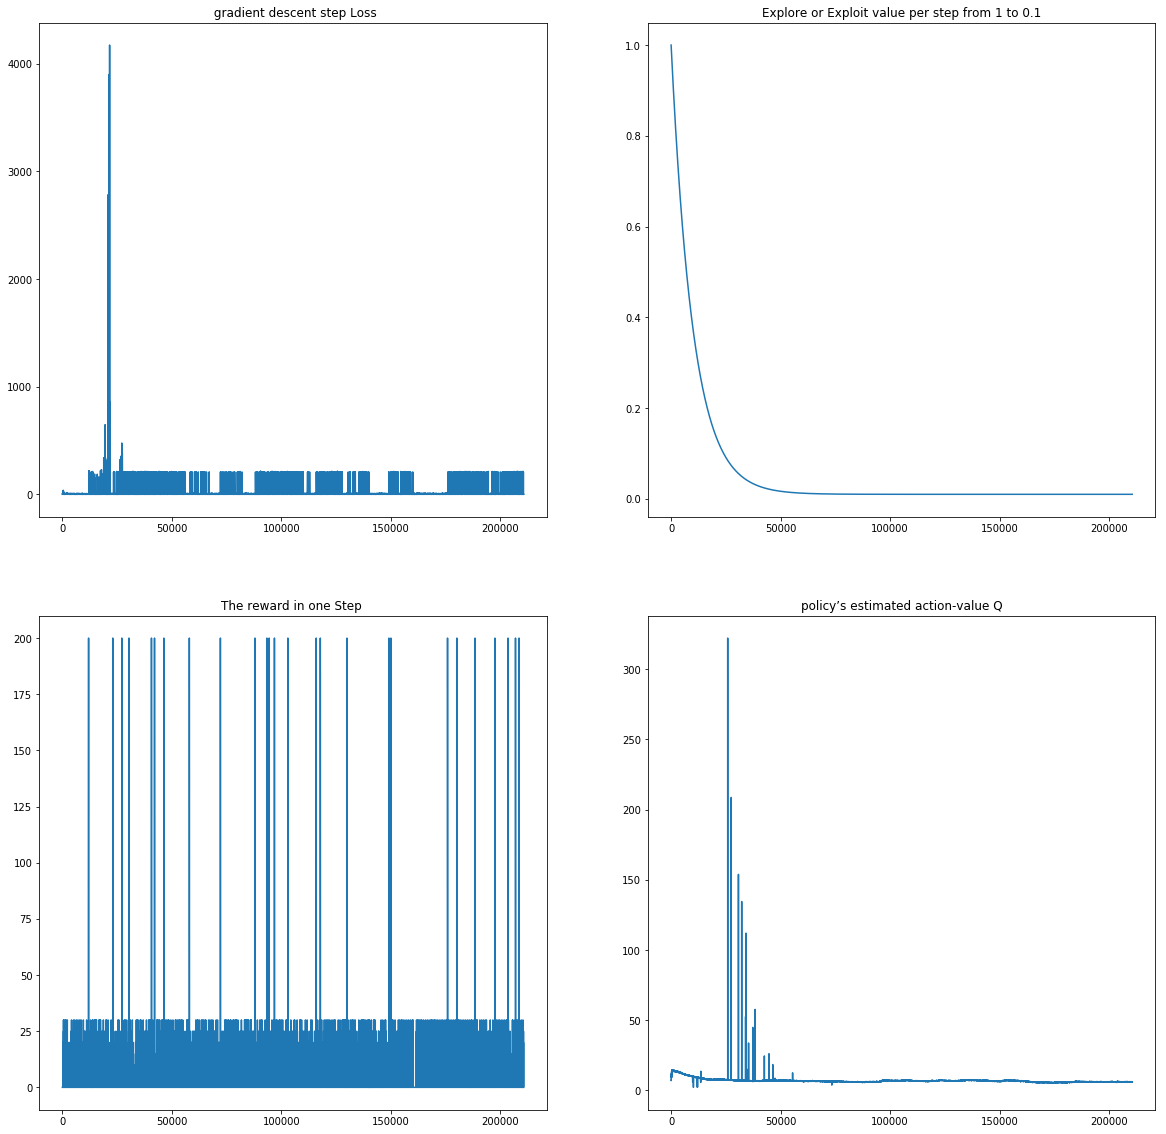

In [50]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_ddqn_orignal_24_24_opt_step")

In [58]:
space_invaders_ddqn_orignal_24_24_otsu =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =250,
                                     preprocess_method = "THRESH_OTSU_GaussianBlur_50",
                                     result = space_invaders_ddqn_orignal_24_24_otsu, 
                                     save_network_path  = "space_invaders_ddqn_orignal_24_24_otsu.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "ddqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24",#deep_mind fully_connected_cnn_24_24
                                     update_target_every = 500,
                                     learning_rate = 0.0005 
                                     )   
result = space_invaders_ddqn_orignal_24_24_otsu  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_86 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_87 (Dense)             (None, 6)                 150       
Total params: 170,118
Trainable params: 170,118
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_89 (Dense)             (None, 24)                600       
_________________________________________________________________
dens

 step= 29293 ,  Ep=   40 , loss=   1.867 explore value =   0.063  score=  90.000 , reward mean=   0.128  ,Q mean =  28.219 , Q best= 209.425  Successfully saved network.
 step= 29956 ,  Ep=   41 , loss=   2.672 explore value =   0.060  score= 320.000 , reward mean=   0.432  ,Q mean =  28.787 , Q best= 209.425  Successfully saved network.
 step= 30357 ,  Ep=   42 , loss=   0.453 explore value =   0.058  score= 100.000 , reward mean=   0.151  ,Q mean =  34.578 , Q best= 209.425  Successfully saved network.
 step= 31069 ,  Ep=   43 , loss=   0.342 explore value =   0.054  score=  10.000 , reward mean=   0.025  ,Q mean =  50.280 , Q best= 209.425  Successfully saved network.
 step= 31621 ,  Ep=   44 , loss=   0.244 explore value =   0.052  score=  90.000 , reward mean=   0.126  ,Q mean =  31.115 , Q best= 209.425  Successfully saved network.
 step= 32493 ,  Ep=   45 , loss=   1.168 explore value =   0.048  score=  70.000 , reward mean=   0.127  ,Q mean =  39.651 , Q best= 209.425  Successf

 step= 70531 ,  Ep=   88 , loss=   3.242 explore value =   0.011  score= 655.000 , reward mean=   0.423  ,Q mean =  11.174 , Q best= 209.425  Successfully saved network.
 step= 71326 ,  Ep=   89 , loss=   0.147 explore value =   0.011  score= 115.000 , reward mean=   0.132  ,Q mean =  13.646 , Q best= 209.425  Successfully saved network.
 step= 72887 ,  Ep=   90 , loss=   0.011 explore value =   0.011  score= 105.000 , reward mean=   0.132  ,Q mean =  14.708 , Q best= 209.425  Successfully saved network.
 step= 73597 ,  Ep=   91 , loss=   1.370 explore value =   0.011  score= 260.000 , reward mean=   0.167  ,Q mean =  11.170 , Q best= 209.425  Successfully saved network.
 step= 74239 ,  Ep=   92 , loss=   0.579 explore value =   0.011  score=  55.000 , reward mean=   0.077  ,Q mean =  11.922 , Q best= 209.425  Successfully saved network.
 step= 75630 ,  Ep=   93 , loss=   0.066 explore value =   0.011  score=  30.000 , reward mean=   0.047  ,Q mean =  15.097 , Q best= 209.425  Successf

 step= 113473 ,  Ep=  136 , loss=   0.106 explore value =   0.010  score= 215.000 , reward mean=   0.248  ,Q mean =  10.246 , Q best= 209.425  Successfully saved network.
 step= 114147 ,  Ep=  137 , loss=   0.054 explore value =   0.010  score= 105.000 , reward mean=   0.162  ,Q mean =  12.946 , Q best= 209.425  Successfully saved network.
 step= 114934 ,  Ep=  138 , loss=   2.110 explore value =   0.010  score= 340.000 , reward mean=   0.504  ,Q mean =  10.418 , Q best= 209.425  Successfully saved network.
 step= 115336 ,  Ep=  139 , loss=   0.307 explore value =   0.010  score= 210.000 , reward mean=   0.267  ,Q mean =   9.992 , Q best= 209.425  Successfully saved network.
 step= 115681 ,  Ep=  140 , loss=   2.154 explore value =   0.010  score=  50.000 , reward mean=   0.124  ,Q mean =  11.515 , Q best= 209.425  Successfully saved network.
 step= 117143 ,  Ep=  141 , loss=   4.673 explore value =   0.010  score=  85.000 , reward mean=   0.246  ,Q mean =  15.067 , Q best= 209.425  Su

 step= 159250 ,  Ep=  184 , loss=   0.010 explore value =   0.010  score= 175.000 , reward mean=   0.223  ,Q mean =   6.524 , Q best= 209.425  Successfully saved network.
 step= 160468 ,  Ep=  185 , loss=   0.519 explore value =   0.010  score= 235.000 , reward mean=   0.333  ,Q mean =   6.404 , Q best= 209.425  Successfully saved network.
 step= 161098 ,  Ep=  186 , loss=   1.144 explore value =   0.010  score= 450.000 , reward mean=   0.369  ,Q mean =   6.354 , Q best= 209.425  Successfully saved network.
 step= 161689 ,  Ep=  187 , loss=   3.188 explore value =   0.010  score= 150.000 , reward mean=   0.238  ,Q mean =   6.339 , Q best= 209.425  Successfully saved network.
 step= 162860 ,  Ep=  188 , loss=   0.241 explore value =   0.010  score= 185.000 , reward mean=   0.313  ,Q mean =   6.303 , Q best= 209.425  Successfully saved network.
 step= 164419 ,  Ep=  189 , loss=   0.013 explore value =   0.010  score= 150.000 , reward mean=   0.128  ,Q mean =   6.143 , Q best= 209.425  Su

 step= 206178 ,  Ep=  232 , loss=   0.012 explore value =   0.010  score= 220.000 , reward mean=   0.259  ,Q mean =   6.079 , Q best= 209.425  Successfully saved network.
 step= 206799 ,  Ep=  233 , loss=   0.130 explore value =   0.010  score= 370.000 , reward mean=   0.305  ,Q mean =   5.979 , Q best= 209.425  Successfully saved network.
 step= 207968 ,  Ep=  234 , loss=   5.266 explore value =   0.010  score= 155.000 , reward mean=   0.250  ,Q mean =   5.925 , Q best= 209.425  Successfully saved network.
 step= 208792 ,  Ep=  235 , loss=   0.516 explore value =   0.010  score= 225.000 , reward mean=   0.192  ,Q mean =   5.937 , Q best= 209.425  Successfully saved network.
 step= 209897 ,  Ep=  236 , loss=   0.013 explore value =   0.010  score= 290.000 , reward mean=   0.352  ,Q mean =   5.790 , Q best= 209.425  Successfully saved network.
 step= 210396 ,  Ep=  237 , loss=   0.012 explore value =   0.010  score= 255.000 , reward mean=   0.231  ,Q mean =   5.782 , Q best= 209.425  Su

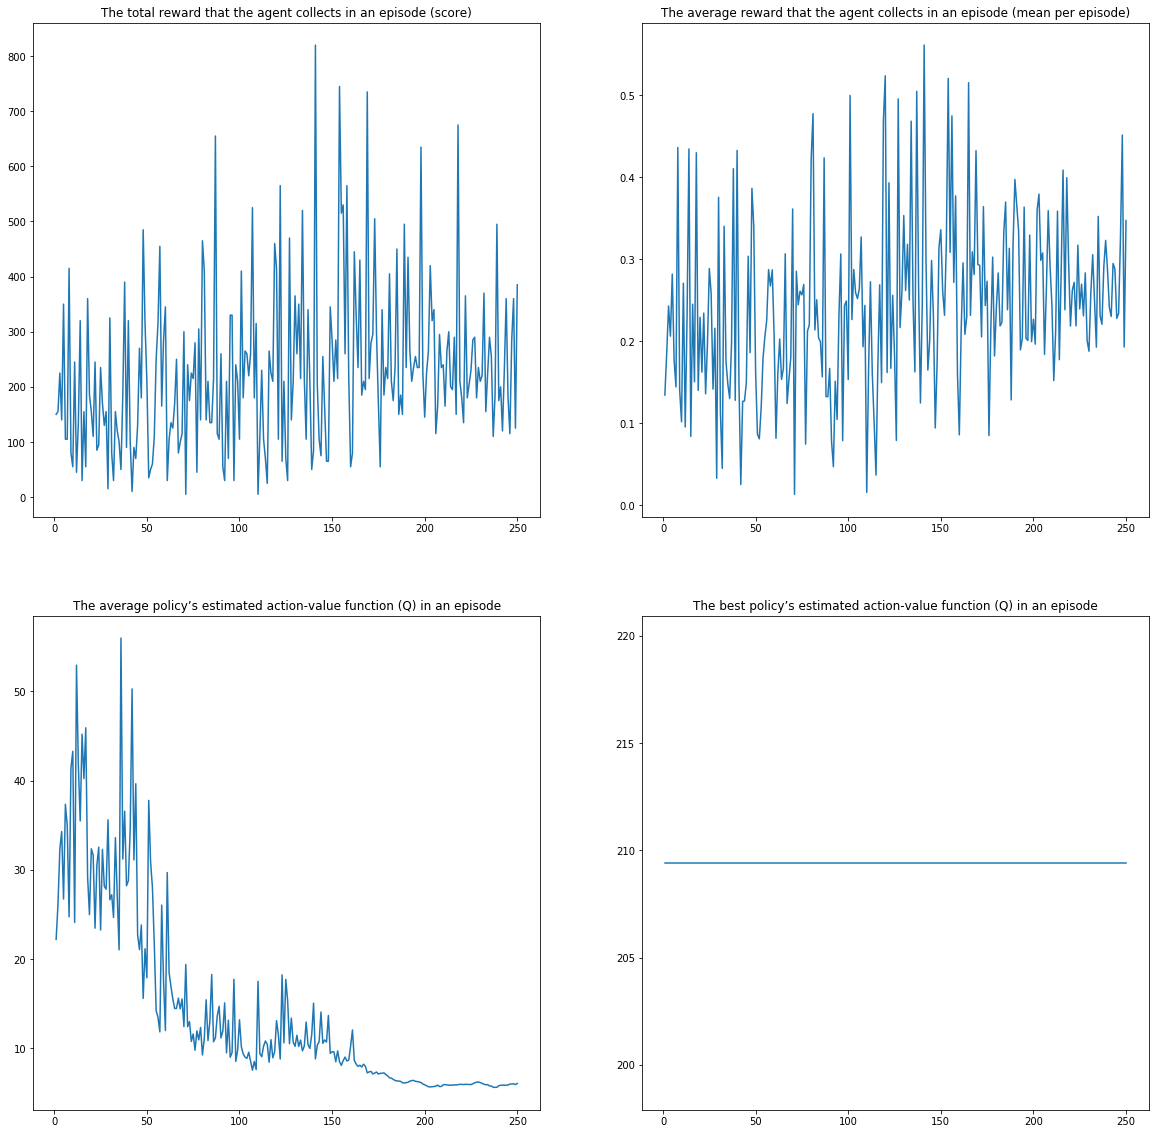

In [59]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_ddqn_orignal_24_24_otsu_episodes")

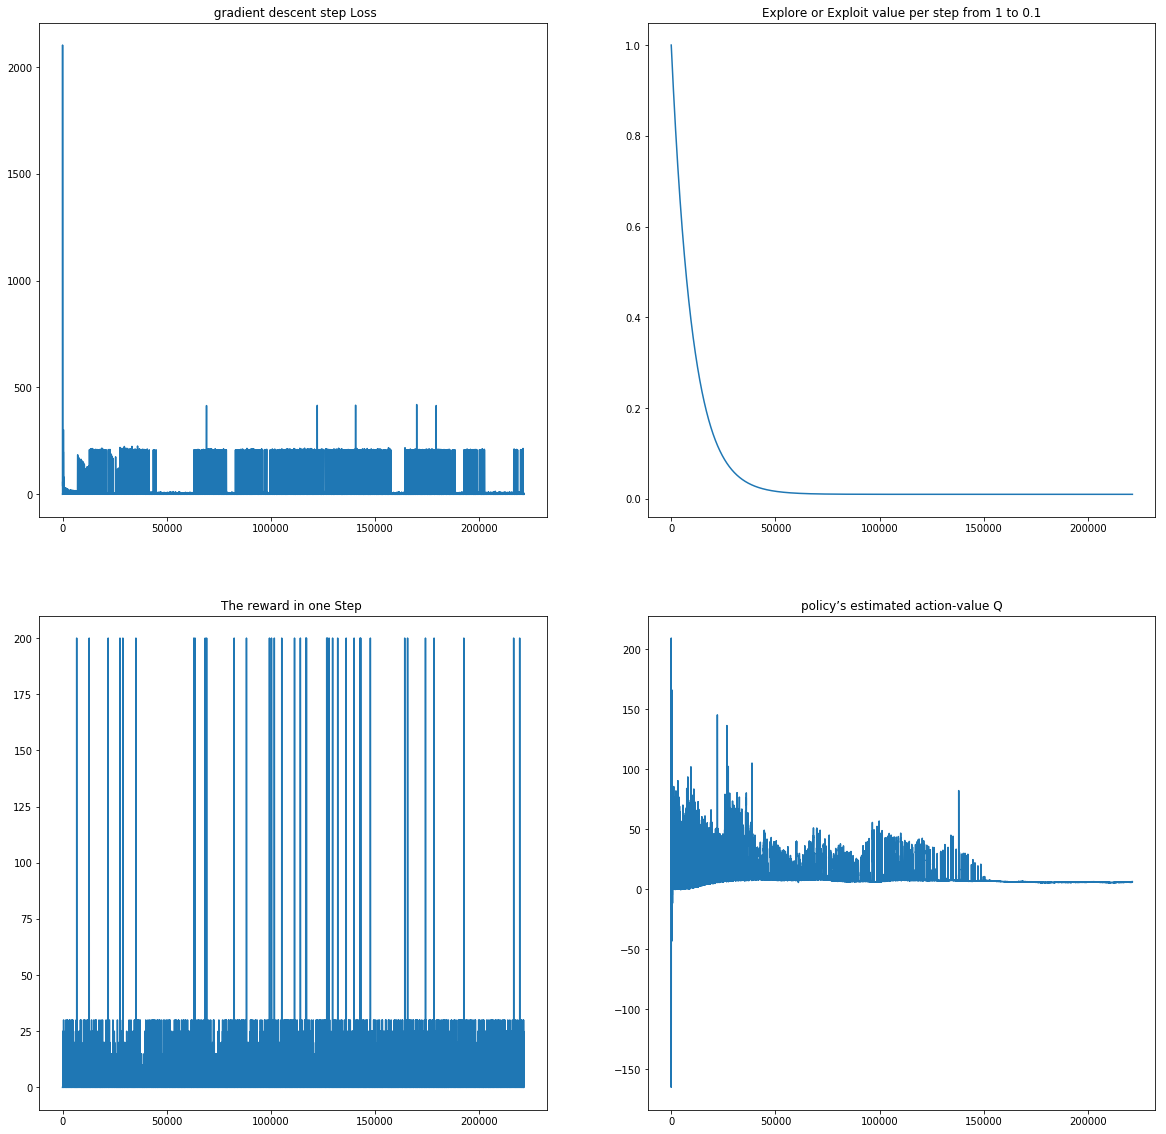

In [60]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_ddqn_orignal_24_24_otsu_step")

In [61]:
space_invaders_ddqn_orignal_24_24_otsu_opt =  defaultdict() 

run_DQN_agent_to_play_space_invaders(num_episodes =750,
                                     preprocess_method = "THRESH_OTSU_GaussianBlur_50",
                                     result = space_invaders_ddqn_orignal_24_24_otsu_opt, 
                                     save_network_path  = "space_invaders_ddqn_orignal_24_24_otsu.h5",
                                     allowRender =  False, 
                                     number_of_frames  = 1 ,
                                     network_type = "ddqn", # duel_dqn dqn ddqn
                                     cnn_nework = "fully_connected_cnn_24_24",#deep_mind fully_connected_cnn_24_24
                                     update_target_every = 500,
                                     learning_rate = 0.0005 
                                     )   
result = space_invaders_ddqn_orignal_24_24_otsu_opt  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_92 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_93 (Dense)             (None, 6)                 150       
Total params: 170,118
Trainable params: 170,118
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 24)                169368    
_________________________________________________________________
dense_95 (Dense)             (None, 24)                600       
_________________________________________________________________
dens

 step= 34737 ,  Ep=   40 , loss=   2.029 explore value =   0.041  score= 150.000 , reward mean=   0.237  ,Q mean =   7.181 , Q best=  20.876  Successfully saved network.
 step= 36010 ,  Ep=   41 , loss=   3.182 explore value =   0.037  score= 360.000 , reward mean=   0.306  ,Q mean =   6.995 , Q best=  20.876  Successfully saved network.
 step= 36618 ,  Ep=   42 , loss=   0.012 explore value =   0.035  score= 485.000 , reward mean=   0.381  ,Q mean =   6.877 , Q best=  20.876  Successfully saved network.
 step= 37255 ,  Ep=   43 , loss=   0.504 explore value =   0.034  score= 220.000 , reward mean=   0.362  ,Q mean =   6.874 , Q best=  20.876  Successfully saved network.
 step= 38236 ,  Ep=   44 , loss=   0.503 explore value =   0.032  score= 150.000 , reward mean=   0.235  ,Q mean =   6.810 , Q best=  20.876  Successfully saved network.
 step= 39052 ,  Ep=   45 , loss=   0.013 explore value =   0.030  score= 470.000 , reward mean=   0.479  ,Q mean =   6.806 , Q best=  20.876  Successf

 step= 79392 ,  Ep=   88 , loss=   0.011 explore value =   0.010  score= 145.000 , reward mean=   0.207  ,Q mean =   5.798 , Q best=  20.876  Successfully saved network.
 step= 80234 ,  Ep=   89 , loss=   0.009 explore value =   0.010  score= 170.000 , reward mean=   0.249  ,Q mean =   5.692 , Q best=  20.876  Successfully saved network.
 step= 80887 ,  Ep=   90 , loss=   0.164 explore value =   0.010  score= 130.000 , reward mean=   0.154  ,Q mean =   5.660 , Q best=  20.876  Successfully saved network.
 step= 81739 ,  Ep=   91 , loss=   0.005 explore value =   0.010  score= 110.000 , reward mean=   0.168  ,Q mean =   5.522 , Q best=  20.876  Successfully saved network.
 step= 82745 ,  Ep=   92 , loss=   0.011 explore value =   0.010  score= 225.000 , reward mean=   0.264  ,Q mean =   5.547 , Q best=  20.876  Successfully saved network.
 step= 84231 ,  Ep=   93 , loss=   4.903 explore value =   0.010  score= 195.000 , reward mean=   0.194  ,Q mean =   5.530 , Q best=  20.876  Successf

 step= 124514 ,  Ep=  136 , loss=   3.156 explore value =   0.010  score= 255.000 , reward mean=   0.213  ,Q mean =   6.347 , Q best=  20.876  Successfully saved network.
 step= 125094 ,  Ep=  137 , loss=   0.014 explore value =   0.010  score= 145.000 , reward mean=   0.232  ,Q mean =   6.305 , Q best=  20.876  Successfully saved network.
 step= 125764 ,  Ep=  138 , loss=   0.016 explore value =   0.010  score= 220.000 , reward mean=   0.379  ,Q mean =   6.326 , Q best=  20.876  Successfully saved network.
 step= 126933 ,  Ep=  139 , loss=   1.139 explore value =   0.010  score= 240.000 , reward mean=   0.358  ,Q mean =   6.343 , Q best=  20.876  Successfully saved network.
 step= 127574 ,  Ep=  140 , loss=   0.244 explore value =   0.010  score= 235.000 , reward mean=   0.201  ,Q mean =   6.386 , Q best=  20.876  Successfully saved network.
 step= 128675 ,  Ep=  141 , loss=   0.018 explore value =   0.010  score= 165.000 , reward mean=   0.257  ,Q mean =   6.333 , Q best=  20.876  Su

 step= 169899 ,  Ep=  184 , loss=   0.009 explore value =   0.010  score= 240.000 , reward mean=   0.328  ,Q mean =   6.076 , Q best=  20.876  Successfully saved network.
 step= 170516 ,  Ep=  185 , loss=   0.128 explore value =   0.010  score= 170.000 , reward mean=   0.256  ,Q mean =   6.079 , Q best=  20.876  Successfully saved network.
 step= 171434 ,  Ep=  186 , loss=   0.024 explore value =   0.010  score=  90.000 , reward mean=   0.146  ,Q mean =   6.018 , Q best=  20.876  Successfully saved network.
 step= 172104 ,  Ep=  187 , loss=   0.507 explore value =   0.010  score= 480.000 , reward mean=   0.523  ,Q mean =   5.981 , Q best=  20.876  Successfully saved network.
 step= 172912 ,  Ep=  188 , loss=   0.020 explore value =   0.010  score= 105.000 , reward mean=   0.157  ,Q mean =   6.048 , Q best=  20.876  Successfully saved network.
 step= 173904 ,  Ep=  189 , loss=   2.047 explore value =   0.010  score= 215.000 , reward mean=   0.266  ,Q mean =   6.130 , Q best=  20.876  Su

 step= 214685 ,  Ep=  232 , loss=   0.010 explore value =   0.010  score= 430.000 , reward mean=   0.448  ,Q mean =   5.430 , Q best=  20.876  Successfully saved network.
 step= 215319 ,  Ep=  233 , loss=   0.130 explore value =   0.010  score= 155.000 , reward mean=   0.110  ,Q mean =   5.472 , Q best=  20.876  Successfully saved network.
 step= 216114 ,  Ep=  234 , loss=   0.128 explore value =   0.010  score= 360.000 , reward mean=   0.568  ,Q mean =   5.447 , Q best=  20.876  Successfully saved network.
 step= 217134 ,  Ep=  235 , loss=   0.019 explore value =   0.010  score= 120.000 , reward mean=   0.151  ,Q mean =   5.479 , Q best=  20.876  Successfully saved network.
 step= 217639 ,  Ep=  236 , loss=   0.009 explore value =   0.010  score= 190.000 , reward mean=   0.186  ,Q mean =   5.422 , Q best=  20.876  Successfully saved network.
 step= 218545 ,  Ep=  237 , loss=   2.029 explore value =   0.010  score=  75.000 , reward mean=   0.149  ,Q mean =   5.484 , Q best=  20.876  Su

 step= 259626 ,  Ep=  280 , loss=   0.007 explore value =   0.010  score= 175.000 , reward mean=   0.254  ,Q mean =   5.655 , Q best=  20.876  Successfully saved network.
 step= 260398 ,  Ep=  281 , loss=   0.129 explore value =   0.010  score= 260.000 , reward mean=   0.224  ,Q mean =   5.557 , Q best=  20.876  Successfully saved network.
 step= 261044 ,  Ep=  282 , loss=   1.647 explore value =   0.010  score= 160.000 , reward mean=   0.207  ,Q mean =   5.471 , Q best=  20.876  Successfully saved network.
 step= 261431 ,  Ep=  283 , loss=   0.503 explore value =   0.010  score= 150.000 , reward mean=   0.232  ,Q mean =   5.397 , Q best=  20.876  Successfully saved network.
 step= 263002 ,  Ep=  284 , loss=   0.009 explore value =   0.010  score=  90.000 , reward mean=   0.233  ,Q mean =   5.301 , Q best=  20.876  Successfully saved network.
 step= 263649 ,  Ep=  285 , loss=   0.614 explore value =   0.010  score= 505.000 , reward mean=   0.321  ,Q mean =   5.289 , Q best=  20.876  Su

 step= 309509 ,  Ep=  328 , loss=   2.039 explore value =   0.010  score= 235.000 , reward mean=   0.203  ,Q mean =   5.703 , Q best=  20.876  Successfully saved network.
 step= 310679 ,  Ep=  329 , loss=   0.003 explore value =   0.010  score= 235.000 , reward mean=   0.203  ,Q mean =   5.492 , Q best=  20.876  Successfully saved network.
 step= 311280 ,  Ep=  330 , loss=   0.126 explore value =   0.010  score= 235.000 , reward mean=   0.201  ,Q mean =   5.326 , Q best=  20.876  Successfully saved network.
 step= 312010 ,  Ep=  331 , loss=   0.011 explore value =   0.010  score= 165.000 , reward mean=   0.275  ,Q mean =   5.284 , Q best=  20.876  Successfully saved network.
 step= 313167 ,  Ep=  332 , loss=   0.007 explore value =   0.010  score= 275.000 , reward mean=   0.377  ,Q mean =   5.236 , Q best=  20.876  Successfully saved network.
 step= 314353 ,  Ep=  333 , loss=   0.504 explore value =   0.010  score= 235.000 , reward mean=   0.203  ,Q mean =   5.133 , Q best=  20.876  Su

 step= 358366 ,  Ep=  376 , loss=   1.133 explore value =   0.010  score= 260.000 , reward mean=   0.327  ,Q mean =   6.097 , Q best=  20.876  Successfully saved network.
 step= 359400 ,  Ep=  377 , loss= 208.935 explore value =   0.010  score= 160.000 , reward mean=   0.237  ,Q mean =   6.158 , Q best=  20.876  Successfully saved network.
 step= 360565 ,  Ep=  378 , loss=   0.517 explore value =   0.010  score= 505.000 , reward mean=   0.488  ,Q mean =   6.222 , Q best=  20.876  Successfully saved network.
 step= 361245 ,  Ep=  379 , loss=   0.012 explore value =   0.010  score= 235.000 , reward mean=   0.202  ,Q mean =   6.424 , Q best=  20.876  Successfully saved network.
 step= 362359 ,  Ep=  380 , loss=   0.504 explore value =   0.010  score= 185.000 , reward mean=   0.272  ,Q mean =   6.556 , Q best=  20.876  Successfully saved network.
 step= 363242 ,  Ep=  381 , loss=   5.315 explore value =   0.010  score= 270.000 , reward mean=   0.242  ,Q mean =   6.543 , Q best=  20.876  Su

 step= 401896 ,  Ep=  424 , loss=   5.120 explore value =   0.010  score= 180.000 , reward mean=   0.218  ,Q mean =   5.800 , Q best=  20.876  Successfully saved network.
 step= 403384 ,  Ep=  425 , loss=   0.010 explore value =   0.010  score= 180.000 , reward mean=   0.220  ,Q mean =   5.669 , Q best=  20.876  Successfully saved network.
 step= 404219 ,  Ep=  426 , loss=   2.032 explore value =   0.010  score= 590.000 , reward mean=   0.397  ,Q mean =   5.646 , Q best=  20.876  Successfully saved network.
 step= 405034 ,  Ep=  427 , loss=   3.202 explore value =   0.010  score= 210.000 , reward mean=   0.251  ,Q mean =   5.643 , Q best=  20.876  Successfully saved network.
 step= 405845 ,  Ep=  428 , loss=   0.505 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   5.688 , Q best=  20.876  Successfully saved network.
 step= 406639 ,  Ep=  429 , loss=   0.016 explore value =   0.010  score= 180.000 , reward mean=   0.222  ,Q mean =   5.727 , Q best=  20.876  Su

 step= 442710 ,  Ep=  472 , loss=   1.142 explore value =   0.010  score= 265.000 , reward mean=   0.338  ,Q mean =   6.192 , Q best=  20.876  Successfully saved network.
 step= 443326 ,  Ep=  473 , loss=   0.021 explore value =   0.010  score= 225.000 , reward mean=   0.406  ,Q mean =   6.202 , Q best=  20.876  Successfully saved network.
 step= 444786 ,  Ep=  474 , loss=   0.015 explore value =   0.010  score= 160.000 , reward mean=   0.260  ,Q mean =   6.351 , Q best=  20.876  Successfully saved network.
 step= 445653 ,  Ep=  475 , loss=   0.014 explore value =   0.010  score= 505.000 , reward mean=   0.346  ,Q mean =   6.328 , Q best=  20.876  Successfully saved network.
 step= 446274 ,  Ep=  476 , loss=   1.136 explore value =   0.010  score= 260.000 , reward mean=   0.300  ,Q mean =   6.311 , Q best=  20.876  Successfully saved network.
 step= 447143 ,  Ep=  477 , loss= 207.568 explore value =   0.010  score= 240.000 , reward mean=   0.386  ,Q mean =   6.387 , Q best=  20.876  Su

 step= 484906 ,  Ep=  520 , loss=   0.011 explore value =   0.010  score= 185.000 , reward mean=   0.291  ,Q mean =   6.549 , Q best=  20.876  Successfully saved network.
 step= 485550 ,  Ep=  521 , loss=   5.737 explore value =   0.010  score= 130.000 , reward mean=   0.202  ,Q mean =   6.582 , Q best=  20.876  Successfully saved network.
 step= 486200 ,  Ep=  522 , loss=   3.207 explore value =   0.010  score= 135.000 , reward mean=   0.210  ,Q mean =   6.525 , Q best=  20.876  Successfully saved network.
 step= 486588 ,  Ep=  523 , loss=   2.030 explore value =   0.010  score= 195.000 , reward mean=   0.300  ,Q mean =   6.503 , Q best=  20.876  Successfully saved network.
 step= 487073 ,  Ep=  524 , loss=   0.009 explore value =   0.010  score= 105.000 , reward mean=   0.271  ,Q mean =   6.532 , Q best=  20.876  Successfully saved network.
 step= 487784 ,  Ep=  525 , loss=   1.142 explore value =   0.010  score=  75.000 , reward mean=   0.155  ,Q mean =   6.462 , Q best=  20.876  Su

 step= 525838 ,  Ep=  568 , loss=   0.016 explore value =   0.010  score= 235.000 , reward mean=   0.203  ,Q mean =   6.355 , Q best=  20.876  Successfully saved network.
 step= 527019 ,  Ep=  569 , loss=   0.011 explore value =   0.010  score= 150.000 , reward mean=   0.236  ,Q mean =   6.373 , Q best=  20.876  Successfully saved network.
 step= 528175 ,  Ep=  570 , loss=   5.758 explore value =   0.010  score= 235.000 , reward mean=   0.199  ,Q mean =   6.304 , Q best=  20.876  Successfully saved network.
 step= 529470 ,  Ep=  571 , loss=   3.191 explore value =   0.010  score= 235.000 , reward mean=   0.203  ,Q mean =   6.273 , Q best=  20.876  Successfully saved network.
 step= 530633 ,  Ep=  572 , loss=   4.632 explore value =   0.010  score= 320.000 , reward mean=   0.247  ,Q mean =   6.162 , Q best=  20.876  Successfully saved network.
 step= 531726 ,  Ep=  573 , loss=   3.203 explore value =   0.010  score= 235.000 , reward mean=   0.202  ,Q mean =   6.050 , Q best=  20.876  Su

 step= 571929 ,  Ep=  616 , loss=   0.127 explore value =   0.010  score=  75.000 , reward mean=   0.113  ,Q mean =   5.549 , Q best=  20.876  Successfully saved network.
 step= 572596 ,  Ep=  617 , loss=   7.802 explore value =   0.010  score=  30.000 , reward mean=   0.076  ,Q mean =   5.536 , Q best=  20.876  Successfully saved network.
 step= 573444 ,  Ep=  618 , loss=   0.018 explore value =   0.010  score=  75.000 , reward mean=   0.112  ,Q mean =   5.578 , Q best=  20.876  Successfully saved network.
 step= 574258 ,  Ep=  619 , loss=   0.010 explore value =   0.010  score= 210.000 , reward mean=   0.248  ,Q mean =   5.554 , Q best=  20.876  Successfully saved network.
 step= 575059 ,  Ep=  620 , loss=   0.013 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   5.586 , Q best=  20.876  Successfully saved network.
 step= 575852 ,  Ep=  621 , loss=   0.007 explore value =   0.010  score= 155.000 , reward mean=   0.194  ,Q mean =   5.571 , Q best=  20.876  Su

 step= 612509 ,  Ep=  664 , loss=   0.013 explore value =   0.010  score= 210.000 , reward mean=   0.245  ,Q mean =   5.863 , Q best=  20.876  Successfully saved network.
 step= 613327 ,  Ep=  665 , loss=   0.018 explore value =   0.010  score= 530.000 , reward mean=   0.490  ,Q mean =   5.867 , Q best=  20.876  Successfully saved network.
 step= 614112 ,  Ep=  666 , loss=   0.009 explore value =   0.010  score= 105.000 , reward mean=   0.128  ,Q mean =   5.836 , Q best=  20.876  Successfully saved network.
 step= 615092 ,  Ep=  667 , loss=   0.015 explore value =   0.010  score= 180.000 , reward mean=   0.229  ,Q mean =   5.766 , Q best=  20.876  Successfully saved network.
 step= 615899 ,  Ep=  668 , loss=   0.010 explore value =   0.010  score= 460.000 , reward mean=   0.469  ,Q mean =   5.699 , Q best=  20.876  Successfully saved network.
 step= 616730 ,  Ep=  669 , loss=   4.591 explore value =   0.010  score= 210.000 , reward mean=   0.260  ,Q mean =   5.717 , Q best=  20.876  Su

 step= 658061 ,  Ep=  712 , loss=   0.619 explore value =   0.010  score= 195.000 , reward mean=   0.298  ,Q mean =   6.718 , Q best=  20.876  Successfully saved network.
 step= 659238 ,  Ep=  713 , loss=   0.131 explore value =   0.010  score= 100.000 , reward mean=   0.193  ,Q mean =   6.602 , Q best=  20.876  Successfully saved network.
 step= 660053 ,  Ep=  714 , loss=   4.591 explore value =   0.010  score= 510.000 , reward mean=   0.433  ,Q mean =   6.544 , Q best=  20.876  Successfully saved network.
 step= 660868 ,  Ep=  715 , loss=   3.188 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   6.516 , Q best=  20.876  Successfully saved network.
 step= 661678 ,  Ep=  716 , loss=   0.130 explore value =   0.010  score= 180.000 , reward mean=   0.221  ,Q mean =   6.533 , Q best=  20.876  Successfully saved network.
 step= 662490 ,  Ep=  717 , loss=   0.128 explore value =   0.010  score= 390.000 , reward mean=   0.481  ,Q mean =   6.428 , Q best=  20.876  Su

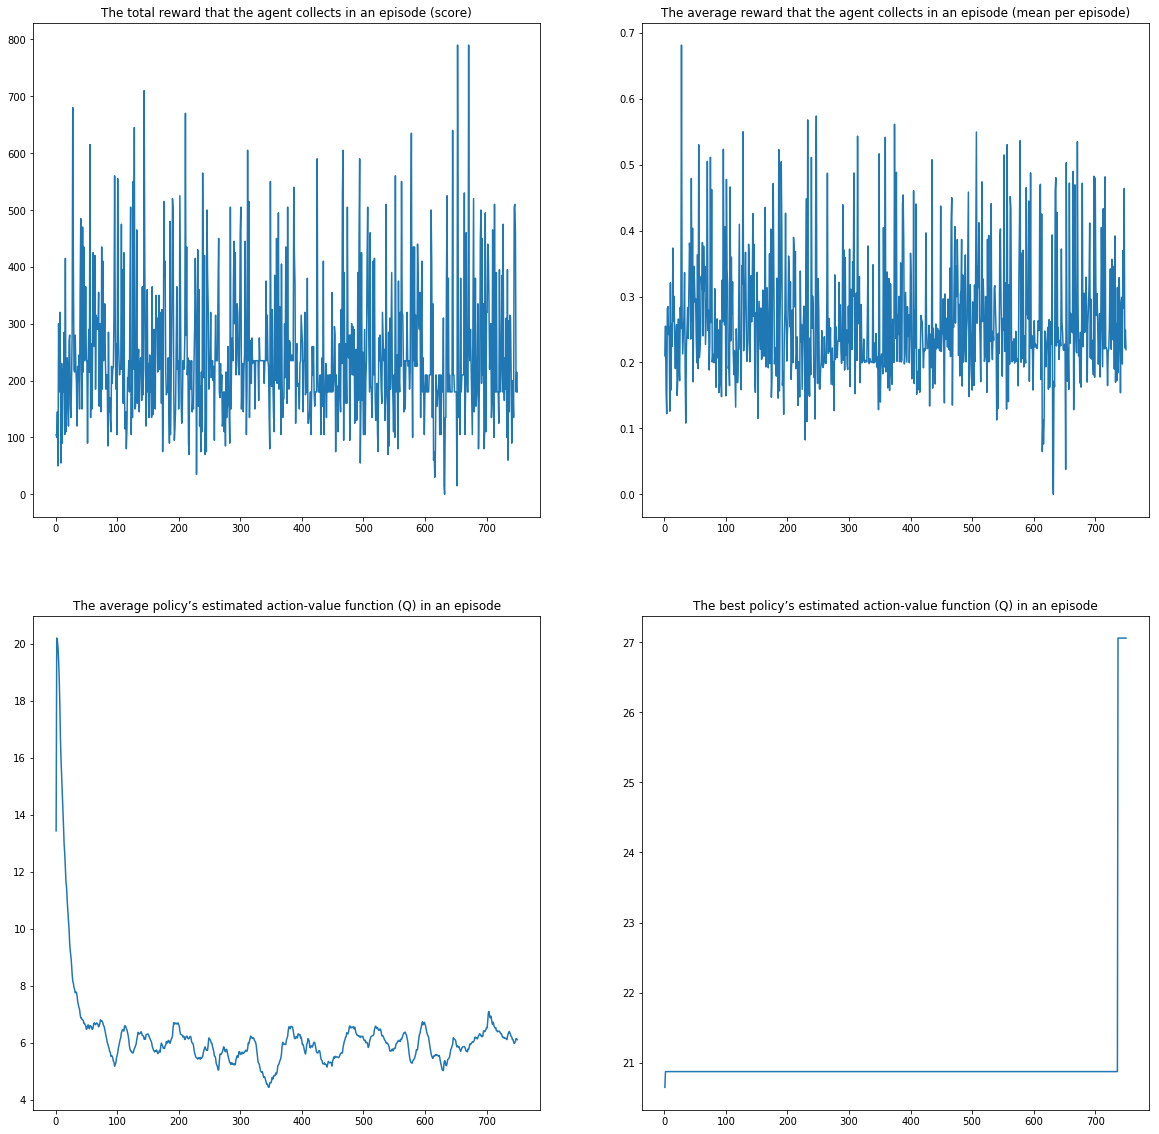

In [66]:
plot_agent_matrix_per_episode(result["episode"],
                              result["score"] ,
                              result["reward_mean"],
                              result["q_mean"],
                              result["q_best"],
                              "space_invaders_ddqn_orignal_24_24_otsu_opt_episodes")

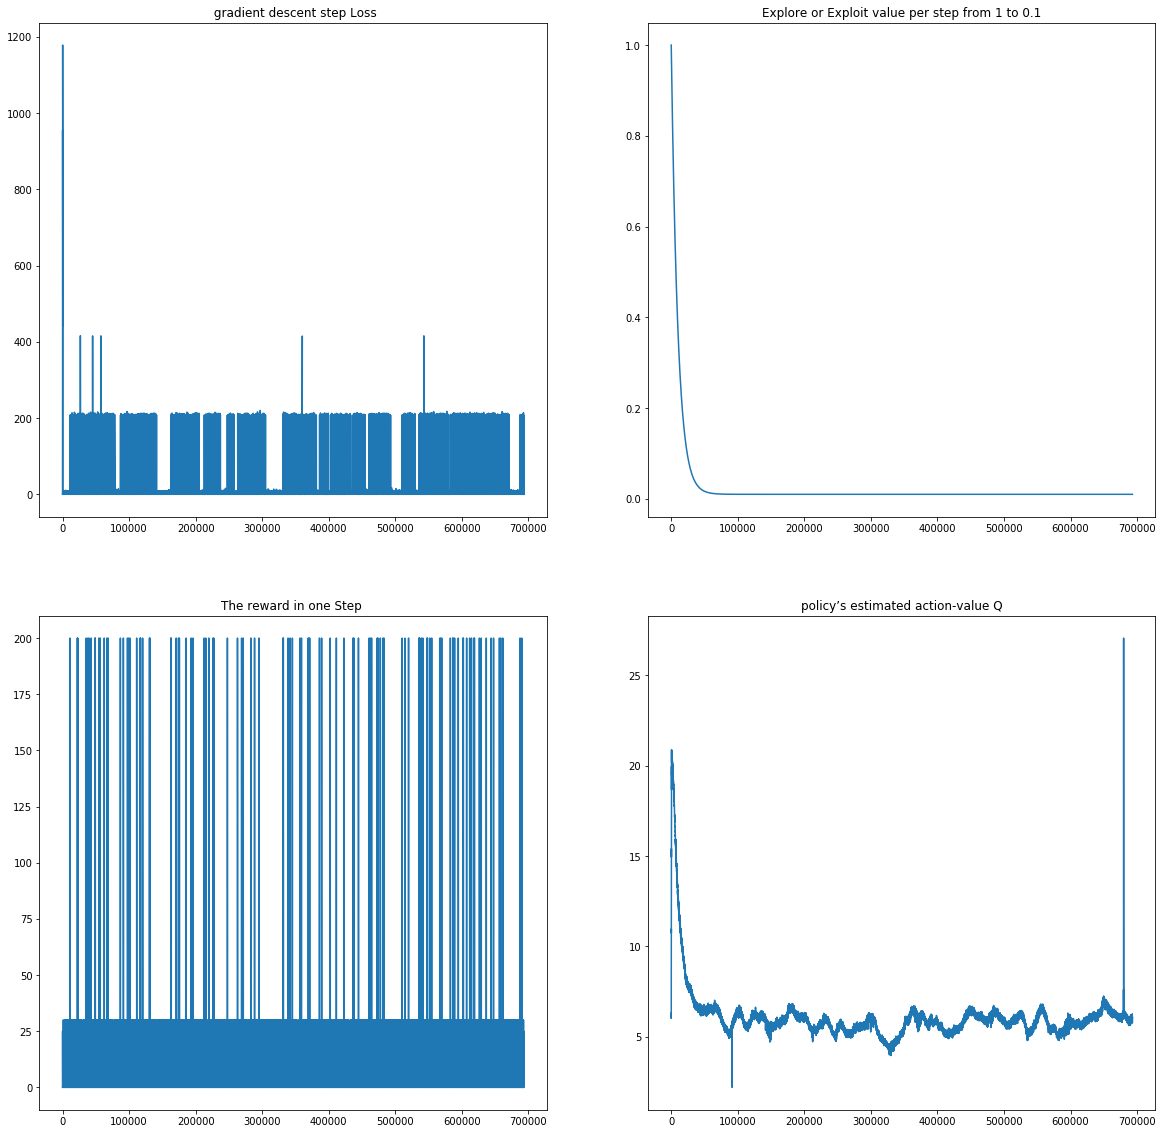

In [65]:
plot_agent_matrix_per_step(result["step"],
                           result["loss"],
                           result["explore"] ,
                           result["reward"] ,
                           result["q"],
                           name="space_invaders_ddqn_orignal_24_24_otsu_opt_step")